<a href="https://colab.research.google.com/github/HebaElwazzan/Modulation-Classification/blob/main/PR_Assignment_4_6521_6492_6360.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulation Classification

In [1]:
#%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import _pickle as cPickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import tensorflow.keras.backend as tfback
from sklearn import preprocessing
import tensorflow as tf

from IPython.core.display import Image



In [2]:
def _get_available_gpus():  
  if tfback._LOCAL_DEVICES is None:  
      devices = tf.config.list_logical_devices()  
      tfback._LOCAL_DEVICES = [x.name for x in devices]  
  return [x for x in tfback._LOCAL_DEVICES if 'device:gpu' in x.lower()]
tfback._get_available_gpus = _get_available_gpus

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# use this for local runtime
path = "E:/A/Term 8/Pattern Recognition/Assignment 4" #configure your own path
file = path + "/RML2016.10b.dat"

In [ ]:
%cd /content/gdrive/MyDrive/pattern-recognition-assignment-4
file = "RML2016.10b.dat"

/content/gdrive/.shortcut-targets-by-id/1NE8NRN1I6DYDHHBr8CjkHCkIUbM0ZFIn/pattern-recognition-assignment-4


In [ ]:
with open(file, 'rb') as f:
    data = cPickle.load(f, encoding="latin1") 
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], data.keys())))), [1,0])
X = [] 
labels = []
for mod in mods:
    for snr in snrs:
        X.append(data[(mod,snr)])
        for i in range(data[(mod,snr)].shape[0]):  labels.append((mod,snr))
X = np.vstack(X)

labels = np.asarray(labels) 


##Data Format

In [ ]:
def plot_signals():
  figure, axes = plt.subplots(4, 3, sharex=True, figsize=(16,8))
  figure.suptitle('Signals')
  mods = ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']
  k = 0 
  for i in range(4):
    for j in range(3):
      try:
        y = data[(mods[k], 0)][0]
        axes[i, j].set_title(mods[k])
        axes[i, j].plot(y[0], color='blue')
        axes[i, j].plot(y[1], color='red')
        k += 1
      except IndexError:
        continue

  

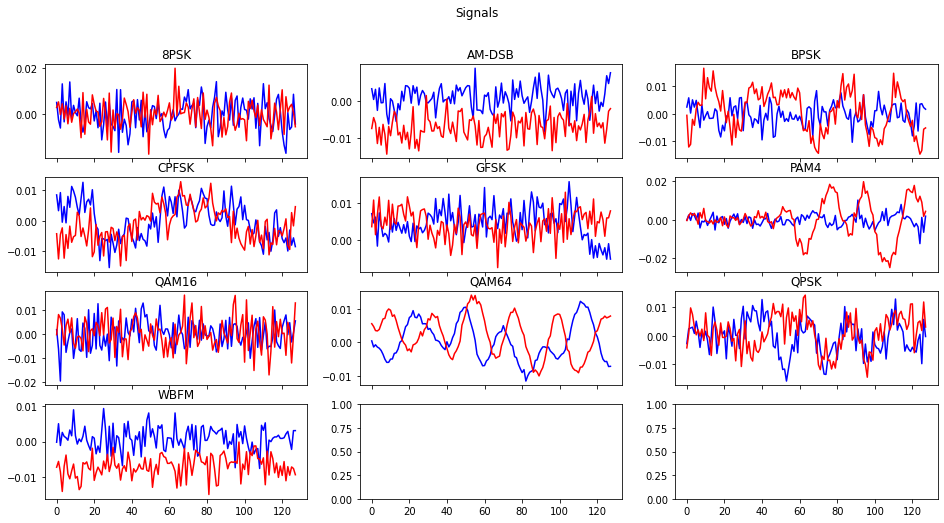

In [ ]:
plot_signals()

In [ ]:
import gc
del(data)
gc.collect()

25828

##Splitting the data

In [ ]:
def split_data(X, y): 
  X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, random_state=42)
  lb=LabelBinarizer()
  lb.fit(y_train[:,0])
  snr_train = y_train[:,1]
  snr_test = y_test[:,1]
  return lb, X_train, lb.transform(y_train[:,0]), snr_train, X_test, lb.transform(y_test[:,0]), snr_test


In [ ]:
lb, X_train, y_train, snr_train, X_test, y_test, snr_test = split_data(X, labels)

In [ ]:
del(X)
del(labels)
gc.collect()

50

In [ ]:
X_train.shape

(840000, 2, 128)

In [ ]:
X_test.shape

(360000, 2, 128)

##Transformer to choose number of features
Feature combinations are as follows:
1. Raw time series (2 channels)
2. First Derivative in time (2 channels)
3. Integral in time (2 channels)
4. Raw time series + first derivative in time (4 channels)
5. Raw time series + integral in time (4 channels)
6. first derivative in time + integral in time (4 channels)
7. Raw time series + first derivative in time + integral in time (6 channels)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import normalize 
class ConcatFeatures(BaseEstimator, TransformerMixin):
  def __init__(self, feat_comb=1) -> None:
      super().__init__()
      self.feat_comb = feat_comb

  def fit(self, X, y=None):
    return self

  def get_raw_features(self, X):
    return X

  def get_first_derivative(self, X):
    return np.stack((normalize(np.gradient(X[:,0], axis = 1)), normalize(np.gradient(X[:,1], axis = 1))), axis=1)

  def get_integral(self, X):
    return np.stack((normalize(np.cumsum(X[:,0], axis = 1)), normalize(np.cumsum(X[:,1], axis = 1))), axis=1)
    
  def transform(self, X):
    nsamples, nx, ny = X.shape
    if self.feat_comb == 1:
      return self.get_raw_features(X).reshape((nsamples,nx*ny))
    if self.feat_comb == 2:
      return self.get_first_derivative(X).reshape((nsamples,nx*ny))
    if self.feat_comb == 3:
      return self.get_integral(X).reshape((nsamples,nx*ny))
    if self.feat_comb == 4:
      return np.stack((self.get_raw_features(X), self.get_first_derivative(X)), axis=1).reshape((nsamples,2*nx*ny))
    if self.feat_comb == 5:
      return np.stack((self.get_raw_features(X), self.get_integral(X)), axis=1).reshape((nsamples,2*nx*ny))
    if self.feat_comb == 6:
      return np.stack((self.get_first_derivative(X), self.get_integral(X)), axis=1).reshape((nsamples,2*nx*ny))
    if self.feat_comb == 7:
      return np.stack((self.get_raw_features(X), self.get_first_derivative(X), self.get_integral(X)), axis=1).reshape((nsamples,3*nx*ny))


In [ ]:
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import StandardScaler 

def create_transformation_pipeline(feat_comb=1):
  return Pipeline([
                          ('concat_features', ConcatFeatures(feat_comb)),
                          ('std_scaler', StandardScaler())
  ])

##Models

In [ ]:
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#TODO: models go here
import keras 
import keras.models as models
from scikeras.wrappers import KerasClassifier
from keras.models import Sequential
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import ShuffleSplit
from tensorflow.keras.layers import BatchNormalization


###CNN model
VT-CNN2 Neural Net model based on https://arxiv.org/abs/1602.04105

In [ ]:
def create_CNN_model(in_shape, dr=0.5, learning_rate=0.001):
  model = models.Sequential()
  model.add(Reshape([1, in_shape[0], in_shape[1]], input_shape=in_shape))
  model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(64, (1, 3), activation="relu", name="conv1",  padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(16, (2, 3), activation="relu", name="conv2", padding="valid",data_format = 'channels_first',  kernel_initializer="glorot_uniform"))
  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(128, activation="relu", name="dense1", kernel_initializer="he_normal"))
  model.add(Dropout(dr))
  model.add(Dense(10,activation='softmax', name="dense2", kernel_initializer="he_normal"))
  optimizer = Adam(learning_rate=learning_rate)
  model.add(Reshape([10]))
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  print(model.summary())
  tf.keras.utils.plot_model(model, "CNN model 1.png", show_shapes=True)
  return model

In [ ]:
def create_CNN_model2(in_shape, dr=0.4, learning_rate=0.001):
  conv1_kernel_shape=(3,1)
  conv1_number_of_filters=64
  conv2_kernel_shape=(3,2)
  conv2_number_of_filters=16
  dense1_size = 128
  dense2_size = 10
  dropout = dr

  # Build model
  model_conv = Sequential()
  model_conv.add(Reshape((128,in_shape[0],1), input_shape=in_shape))
  model_conv.add(Conv2D(conv1_number_of_filters, conv1_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu', kernel_initializer='glorot_uniform'))
  model_conv.add(BatchNormalization())
  model_conv.add(MaxPooling2D())
  model_conv.add(Conv2D(conv2_number_of_filters, conv2_kernel_shape, strides=1,
                   padding='same', data_format='channels_last', activation='relu', kernel_initializer='glorot_uniform'))
  model_conv.add(Flatten())
  model_conv.add(Dropout(rate=1-dropout))
  model_conv.add(Dense(dense1_size, activation='relu', kernel_initializer='glorot_uniform'))
  model_conv.add(Dense(dense2_size, activation='softmax'))

  # Compile model
  model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model_conv.summary()
  Image(tf.keras.utils.plot_model(model_conv, "CNN model 2.png", show_shapes=True))
  return model_conv

In [ ]:
def create_CNN_model3(in_shape, dr=0.5, learning_rate=0.001):
  model = models.Sequential()
  model.add(Reshape([1]+in_shape, input_shape=in_shape))
  model.add(ZeroPadding2D(((0, 0), (2, 2)), data_format = 'channels_first'))
  model.add(Conv2D(256, (1, 3), padding='valid', activation="relu", name="conv1", data_format = 'channels_first', kernel_initializer='glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D(((0, 0), (2, 2)),data_format = 'channels_first'))
  model.add(Conv2D(80, (2, 3), padding="valid", activation="relu", name="conv2", data_format = 'channels_first', kernel_initializer='glorot_uniform'))
  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(256, activation='relu', kernel_initializer='he_normal', name="dense1"))
  model.add(Dropout(dr))
  model.add(Dense( 10, kernel_initializer='he_normal', name="dense2" ))
  model.add(Activation('softmax'))
  model.add(Reshape([10]))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  tf.keras.utils.plot_model(model, "CNN model 3.png", show_shapes=True)
  return model

### Vanilla RNN

In [ ]:
def create_vanilla_RNN(in_shape, dr=0, learning_rate=0.001):
  model = keras.models.Sequential([
                                   keras.layers.SimpleRNN(64, return_sequences=True, dropout=dr, input_shape=in_shape),
                                   keras.layers.SimpleRNN(128),
                                   keras.layers.Dense(10,activation='softmax', name="dense", kernel_initializer="he_normal"),
                                   Reshape([10])
  ])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  print(model.summary())
  tf.keras.utils.plot_model(model, "RNN model 1.png", show_shapes=True)
  return model

### Vanilla LSTM

In [ ]:
def create_LSTM(in_shape, dr=0, learning_rate=0.001):
  model = keras.models.Sequential([
                                   keras.layers.LSTM(64, return_sequences=True, input_shape=in_shape),
                                   keras.layers.LSTM(128, dropout=dr),
                                   keras.layers.Dense(10,activation='softmax', name="dense", kernel_initializer="he_normal"),
                                   Reshape([10])
  ])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  print(model.summary())
  tf.keras.utils.plot_model(model, "LSTM model 1.png", show_shapes=True)
  return model

In [ ]:
def create_LSTM2(in_shape, dr=0, learning_rate=0.001):
  model = keras.models.Sequential([
                                   keras.layers.LSTM(64, return_sequences=True, input_shape=in_shape),
                                   keras.layers.LSTM(128, dropout=dr, return_sequences=True),
                                   keras.layers.LSTM(256, dropout=dr),
                                   keras.layers.Dense(10,activation='softmax', name="dense", kernel_initializer="glorot_uniform"),
                                   Reshape([10])
  ])
  optimizer = Adam(learning_rate=learning_rate)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  print(model.summary())
  tf.keras.utils.plot_model(model, "LSTM model 2.png", show_shapes=True)
  return model

###CLDNN
Convolution layers followed by an LSTM.
Model is based on https://arxiv.org/pdf/1703.09197.pdf

In [ ]:
def create_CLDNN(in_shape, dr=0.6, learning_rate=0.001):
  input = keras.Input(shape=in_shape)
  x = keras.layers.Conv1D(50, kernel_size=8, activation="relu", padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform")(input)
  x = Dropout(dr)(x)
  a = keras.layers.Conv1D(50, kernel_size=8, activation="relu", padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform")(x)
  a = Dropout(dr)(a)
  a = keras.layers.Conv1D(50, kernel_size=8, activation="relu", padding="valid",data_format = 'channels_first', kernel_initializer="glorot_uniform")(a)
  a = Dropout(dr)(a)
  c = keras.layers.concatenate([x, a])
  x = keras.layers.LSTM(64, return_sequences=True, kernel_initializer="glorot_uniform")(c)
  x = keras.layers.LSTM(128, dropout=dr, kernel_initializer="glorot_uniform")(x)
  x = keras.layers.Dense(10,activation='softmax', name="dense", kernel_initializer="he_normal")(x)

  optimizer = Adam(learning_rate=learning_rate)
  model = keras.Model(input, x)
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy"])
  print(model.summary())
  tf.keras.utils.plot_model(model, "CLDNN model 1.png", show_shapes=True)
  return model

## Training the models

In [ ]:
def plot_loss(history): # this function does not work with the keras classifier wrapper
  # Plot history: Loss
  plt.plot(history.history['val_loss'])
  plt.title('Validation loss history')
  plt.ylabel('Loss value')
  plt.xlabel('No. epoch')
  plt.show()

  # Plot history: Accuracy
  plt.plot(history.history['val_accuracy'])
  plt.title('Validation accuracy history')
  plt.ylabel('Accuracy value (%)')
  plt.xlabel('No. epoch')
  plt.show()

In [ ]:
def prep_data(X, feature_comb):
  nsamples, nx, ny = X.shape
  feat_pipeline = create_transformation_pipeline(feature_comb)
  X_transformed = feat_pipeline.fit_transform(X)
  if feature_comb == 1 or feature_comb == 2 or feature_comb == 3:
    shape = list([nx,ny])
  elif feature_comb == 4 or feature_comb == 5 or feature_comb == 6:
    shape = list([2*nx,ny])
  elif feature_comb == 7:
    shape = list([3*nx,ny])
  return X_transformed.reshape(list([nsamples] + shape)), shape

In [ ]:
def train_model(create_model, feature_comb,  model_name, epochs=100, batch_size=1024, dr=0.5, learning_rate=0.001, val_split=0.05, loss_graph=False):
  filepath = model_name + ".wts.h5"
  X_train_transformed, shape = prep_data(X_train, feature_comb)
  model = KerasClassifier(model=create_model, batch_size=batch_size,
                        epochs=epochs,
                        in_shape=shape,
                        dr=dr,
                        learning_rate=learning_rate,
                        verbose=2,
                        callbacks = [
                            keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto'),
                            keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')],
                        validation_split=val_split
                      )
  history = model.fit(X_train_transformed, y_train)
  
  del(model)
  gc.collect()

### Training runs

No real improvement observed by making the LSTM model deeper

In [ ]:
train_model(create_CNN_model, 1, "CNN_model_1")

In [ ]:
train_model(create_CNN_model2, 1, "CNN_model_12", dr=0.4, val_split=0.15)

In [ ]:
train_model(create_CNN_model2, 2, "CNN_model_22", dr=0.4)

In [ ]:
train_model(create_CNN_model3, 1, "CNN_model_13")

In [ ]:
train_model(create_CNN_model2, 4, "CNN_model_42")

In [ ]:
train_model(create_CNN_model2, 5, "CNN_model_52")

In [ ]:
train_model(create_CNN_model2, 6, "CNN_model_62", dr=0.4, val_split=0.05, learning_rate=0.0001)

In [ ]:
train_model(create_CNN_model2, 7, "CNN_model_72", learning_rate=0.0001)

In [ ]:
train_model(create_vanilla_RNN, 1, "RNN_model_1", learning_rate=0.0001)

In [ ]:
train_model(create_LSTM, 1, "LSTM_model_1", learning_rate=0.0001, epochs=200)

In [ ]:
train_model(create_LSTM2, 1, "LSTM_model_12", learning_rate=0.0001, epochs=200)

In [ ]:
train_model(create_vanilla_RNN, 7, "RNN_model_7", learning_rate=0.0001)

In [ ]:
train_model(create_CLDNN, 1, "CLDNN_model_1", learning_rate=0.0001)

In [ ]:
train_model(create_CNN_model2, 3, "CNN_model_32")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 128, 2, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 128, 2, 64)        256       
                                                                 
 batch_normalization (BatchN  (None, 128, 2, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 1, 64)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 1, 16)         6160      
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [ ]:
train_model(create_vanilla_RNN, 2, "RNN_model_2", learning_rate=0.0001)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 2, 64)             12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape_1 (Reshape)         (None, 10)                0         
                                                                 
Total params: 38,346
Trainable params: 38,346
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.09998, saving model to RNN_model_2.wts.h5
780/780 - 13s - loss: 2.3683 - accuracy: 0.0997 - val_loss: 2.3176 - val_acc

In [ ]:
gc.collect()

66528

In [ ]:
train_model(create_LSTM, 2, "LSTM_model_2", epochs=200)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 2, 64)             49408     
                                                                 
 lstm_9 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape_5 (Reshape)         (None, 10)                0         
                                                                 
Total params: 149,514
Trainable params: 149,514
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.28674, saving model to LSTM_model_2.wts.h5
780/780 - 10s - loss: 1.9999 - accuracy: 0.2387 - val_loss: 1.8821 - val_

In [ ]:
gc.collect()

38286

In [ ]:
train_model(create_LSTM2, 2, "LSTM_model_22", epochs=200)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 2, 64)             49408     
                                                                 
 lstm_11 (LSTM)              (None, 2, 128)            98816     
                                                                 
 lstm_12 (LSTM)              (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 reshape_6 (Reshape)         (None, 10)                0         
                                                                 
Total params: 545,034
Trainable params: 545,034
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved

In [ ]:
gc.collect()

56999

In [ ]:
train_model(create_vanilla_RNN, 3, "RNN_model_3")

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 2, 64)             12352     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape_7 (Reshape)         (None, 10)                0         
                                                                 
Total params: 38,346
Trainable params: 38,346
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.22200, saving model to RNN_model_3.wts.h5
780/780 - 8s - loss: 2.1429 - accuracy: 0.1819 - val_loss: 2.0292 - val_accu

In [ ]:
gc.collect()

10902

In [ ]:
train_model(create_LSTM, 3, "LSTM_model_3", epochs=200)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (None, 2, 64)             49408     
                                                                 
 lstm_14 (LSTM)              (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape_8 (Reshape)         (None, 10)                0         
                                                                 
Total params: 149,514
Trainable params: 149,514
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.27512, saving model to LSTM_model_3.wts.h5
780/780 - 9s - loss: 1.9964 - accuracy: 0.2321 - val_loss: 1.8826 - val_a

In [ ]:
gc.collect()

38286

In [ ]:
train_model(create_LSTM2, 3, "LSTM_model_32", epochs=200)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 2, 64)             49408     
                                                                 
 lstm_16 (LSTM)              (None, 2, 128)            98816     
                                                                 
 lstm_17 (LSTM)              (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 reshape_9 (Reshape)         (None, 10)                0         
                                                                 
Total params: 545,034
Trainable params: 545,034
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved

In [ ]:
gc.collect()

452

In [ ]:
train_model(create_vanilla_RNN, 4, "RNN_model_4")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 4, 64)             12352     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               24704     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape (Reshape)           (None, 10)                0         
                                                                 
Total params: 38,346
Trainable params: 38,346
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.29048, saving model to RNN_model_4.wts.h5
780/780 - 16s - loss: 2.0422 - accuracy: 0.2070 - val_loss: 1.7723 - val_accur

In [ ]:
gc.collect()

10903

In [ ]:
train_model(create_LSTM, 4, "LSTM_model_4", epochs=200)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4, 64)             49408     
                                                                 
 lstm_1 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 reshape_1 (Reshape)         (None, 10)                0         
                                                                 
Total params: 149,514
Trainable params: 149,514
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.36569, saving model to LSTM_model_4.wts.h5
780/780 - 15s - loss: 1.7027 - accuracy: 0.3184 - val_loss: 1.5633 - val_

In [ ]:
gc.collect()

38286

In [ ]:
train_model(create_LSTM2, 4, "LSTM_model_42", epochs=200)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 4, 64)             49408     
                                                                 
 lstm_3 (LSTM)               (None, 4, 128)            98816     
                                                                 
 lstm_4 (LSTM)               (None, 256)               394240    
                                                                 
 dense (Dense)               (None, 10)                2570      
                                                                 
 reshape_2 (Reshape)         (None, 10)                0         
                                                                 
Total params: 545,034
Trainable params: 545,034
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/200

Epoch 1: val_accuracy improved

In [ ]:
gc.collect()

56999

In [ ]:
train_model(create_vanilla_RNN, 5, "RNN_model_5")

In [ ]:
gc.collect()

In [ ]:
train_model(create_LSTM, 5, "LSTM_model_5", epochs=200)

In [ ]:
gc.collect()

In [ ]:
train_model(create_LSTM2, 5, "LSTM_model_52", epochs=200)

In [ ]:
gc.collect()

In [ ]:
train_model(create_vanilla_RNN, 6, "RNN_model_6")

In [ ]:
gc.collect()

In [ ]:
train_model(create_LSTM, 6, "LSTM_model_6", epochs=200)

In [ ]:
gc.collect()

In [ ]:
train_model(create_LSTM2, 6, "LSTM_model_62",epochs=200)

In [ ]:
gc.collect()

In [ ]:
train_model(create_CNN_model3, 2, "CNN_model_32")

In [ ]:
gc.collect()

In [ ]:
train_model(create_CLDNN, 1, "CLDNN_model_1", dr=0.6)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2, 128)]     0           []                               
                                                                                                  
 conv1d_12 (Conv1D)             (None, 50, 121)      850         ['input_9[0][0]']                
                                                                                                  
 conv1d_13 (Conv1D)             (None, 50, 114)      20050       ['conv1d_12[0][0]']              
                                                                                                  
 conv1d_14 (Conv1D)             (None, 50, 107)      20050       ['conv1d_13[0][0]']              
                                                                                            

In [ ]:
train_model(create_CLDNN, 1, "CLDNN_model_1")

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 2, 128)]     0           []                               
                                                                                                  
 conv1d_15 (Conv1D)             (None, 50, 121)      850         ['input_12[0][0]']               
                                                                                                  
 dropout_35 (Dropout)           (None, 50, 121)      0           ['conv1d_15[0][0]']              
                                                                                                  
 conv1d_16 (Conv1D)             (None, 50, 114)      20050       ['dropout_35[0][0]']             
                                                                                            

In [ ]:
gc.collect()

347

In [ ]:
train_model(create_CLDNN, 4, "CLDNN_model_4")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 128)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 121)      1650        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 50, 121)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 114)      20050       ['dropout[0][0]']                
                                                                                              

In [ ]:
gc.collect()

250

In [ ]:
train_model(create_CLDNN, 7, "CLDNN_model_7")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6, 128)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 50, 121)      2450        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 50, 121)      0           ['conv1d[0][0]']                 
                                                                                                  
 conv1d_1 (Conv1D)              (None, 50, 114)      20050       ['dropout[0][0]']                
                                                                                              

## Test the models

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
from sklearn.metrics import confusion_matrix
def conf_mat(y_test, y_pred,title):
  ax = plt.axes()
  y_test_inv = lb.inverse_transform(y_test)
  y_pred_inv = lb.inverse_transform(y_pred)
  matrix_confusion = confusion_matrix(y_test_inv, y_pred_inv)
  sns.heatmap(matrix_confusion, square=True, cmap='Blues', xticklabels=mods, yticklabels=mods, ax=ax)
  ax.set_title(title)
  plt.show()

In [ ]:
def test_model(model_name, feature_comb, title, snr=None, plot=True):
  model = keras.models.load_model(model_name)
  if snr is None:
    X_test_snr = X_test 
    y_test_snr = y_test 
  else:
    X_test_snr = X_test[np.where(np.array(snr_test)==snr)]
    y_test_snr = y_test[np.where(np.array(snr_test)==snr)] 
  X_test_transformed = prep_data(X_test_snr, feature_comb)[0]
  predictions = model.predict(X_test_transformed)
  for j in range(len(predictions)):
    idx = np.argmax(predictions[j])
    for i in range(len(predictions[j])):
      if i == idx:
        predictions[j][i] = 1
      else:
        predictions[j][i] = 0
  predictions = predictions.astype(int)
  acc = accuracy_score(y_test_snr, predictions)
  print(title + " accuracy = " + str(acc))
  if plot:
    conf_mat(y_test_snr, predictions, title)
  return acc

In [ ]:
def plot_snrs_acc(model_name, title, feat_comb=1):
  accuracies = []
  for snr in snrs:
    accuracies.append(test_model(model_name, feat_comb, snr=str(snr), title=title+" SNR="+str(snr)))
  sns.lineplot(x=snrs, y=accuracies)
  print("Best accuracy = " + str(max(accuracies)) + " at SNR " + str(snrs[np.argmax(accuracies)]))

In [ ]:
def get_model_name(model):
  splt = model.split("_")
  model_name = splt[0]
  if int(splt[-1].split(".")[0]) < 9:
    model_name += " 1"
  else:
    model_name += " " + splt[-1][1]
  combination = splt[-1][0]
  return model_name, int(combination)

In [7]:
import os
import pandas as pd
def test_all_models(plot=True):
  df = pd.DataFrame()
  models = []
  for file in os.listdir():
    if file.endswith('.wts.h5'):
        models.append(file)
  i = 0      
  for model in models:
    i = i + 1
    model_name, combination = get_model_name(model)
    print(str(i)+ "/" + str(len(models)))
    print(model)
    for snr in snrs:
      accuracy = test_model(model, combination, snr=str(snr), title=model_name +" SNR=" + str(snr) + " combination " + str(combination), plot=False)
      df = df.append({"Model_Name":model_name, "Combination":combination, "SNR":snr, "Accuracy":accuracy}, ignore_index=True)
      df.to_pickle("a_file.pkl")
    print("-------------------------------------------------------")

  if plot:
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.lineplot(data=df, x="SNR", y="Accuracy", hue="Model_Name", size="Combination", sizes=(.25, 2.5))   
  return df


In [ ]:
df = test_all_models(plot = False)

1/37
CNN_model_1.wts.h5
CNN 1 SNR=-20 combination 1 accuracy = 0.10463178940353215
CNN 1 SNR=-18 combination 1 accuracy = 0.11247647514668438
CNN 1 SNR=-16 combination 1 accuracy = 0.11634181257570753
CNN 1 SNR=-14 combination 1 accuracy = 0.1297103448275862
CNN 1 SNR=-12 combination 1 accuracy = 0.1525357895905005
CNN 1 SNR=-10 combination 1 accuracy = 0.2129639828174909
CNN 1 SNR=-8 combination 1 accuracy = 0.3354242509101092
CNN 1 SNR=-6 combination 1 accuracy = 0.480608492143096
CNN 1 SNR=-4 combination 1 accuracy = 0.6005335111703901
CNN 1 SNR=-2 combination 1 accuracy = 0.6692080805832267
CNN 1 SNR=0 combination 1 accuracy = 0.727781781892776
CNN 1 SNR=2 combination 1 accuracy = 0.7522512506948305
CNN 1 SNR=4 combination 1 accuracy = 0.7574318283415288
CNN 1 SNR=6 combination 1 accuracy = 0.7650055991041433
CNN 1 SNR=8 combination 1 accuracy = 0.7584731636848538
CNN 1 SNR=10 combination 1 accuracy = 0.7567310914981566
CNN 1 SNR=12 combination 1 accuracy = 0.7579233156028369
CNN 1

In [9]:
unpickled_df = pd.read_pickle("/content/gdrive/MyDrive/pattern-recognition-assignment-4/a_file.pkl")  

In [11]:
unpickled_df.head

<bound method NDFrame.head of     Model_Name  Combination   SNR  Accuracy
0        CNN 1          1.0 -20.0  0.104632
1        CNN 1          1.0 -18.0  0.112476
2        CNN 1          1.0 -16.0  0.116342
3        CNN 1          1.0 -14.0  0.129710
4        CNN 1          1.0 -12.0  0.152536
..         ...          ...   ...       ...
735    CLDNN 1          7.0  10.0  0.879734
736    CLDNN 1          7.0  12.0  0.884696
737    CLDNN 1          7.0  14.0  0.883509
738    CLDNN 1          7.0  16.0  0.889192
739    CLDNN 1          7.0  18.0  0.890797

[740 rows x 4 columns]>

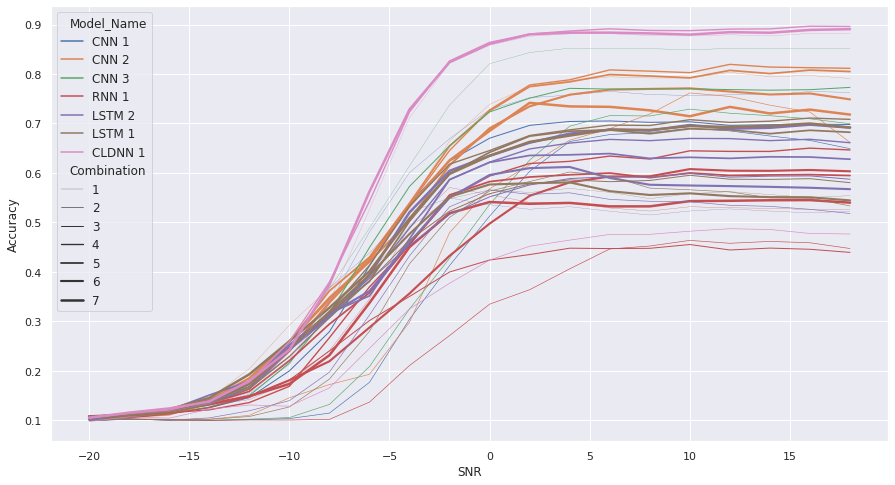

In [14]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=unpickled_df, x="SNR", y="Accuracy", hue="Model_Name", size="Combination", sizes=(.25, 2.5))    

### Testing runs:

Accuracy =  0.5394055555555556


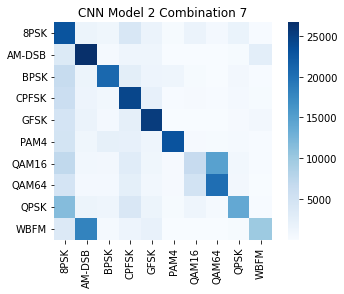

0.5394055555555556

In [ ]:
test_model("CNN_model_72.wts.h5", 7, title="CNN Model 2 Combination 7")

Accuracy =  0.5348972222222222


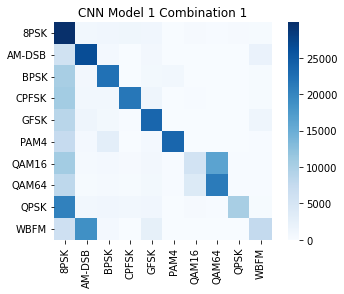

0.5348972222222222

In [ ]:
test_model("CNN_model_1.wts.h5", 1, title="CNN Model 1 Combination 1")

Accuracy =  0.5535138888888889


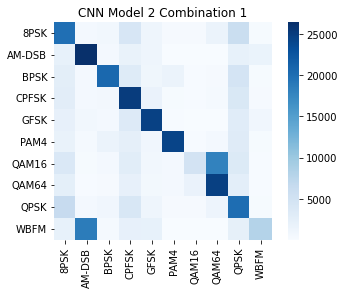

0.5535138888888889

In [ ]:
test_model("CNN_model_12.wts.h5", 1, title="CNN Model 2 Combination 1")

Accuracy =  0.43448888888888887


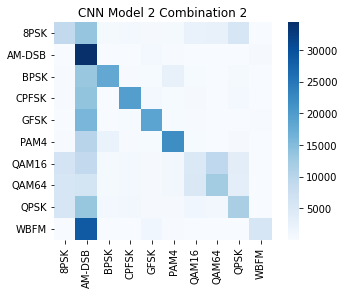

0.43448888888888887

In [ ]:
test_model("CNN_model_22.wts.h5", 2, title="CNN Model 2 Combination 2")

Accuracy =  0.5830416666666667


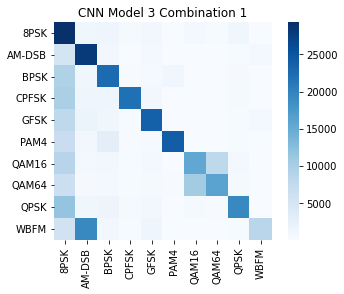

0.5830416666666667

In [ ]:
test_model("CNN_model_13.wts.h5", 1, title="CNN Model 3 Combination 1")

Accuracy =  0.5170305555555555


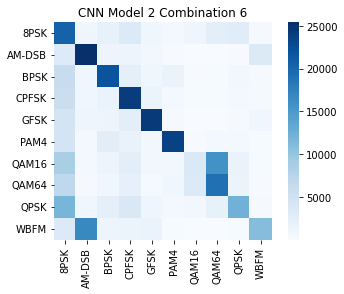

0.5170305555555555

In [ ]:
test_model("CNN_model_62.wts.h5", 6, title="CNN Model 2 Combination 6")

Accuracy =  0.8208127737428619


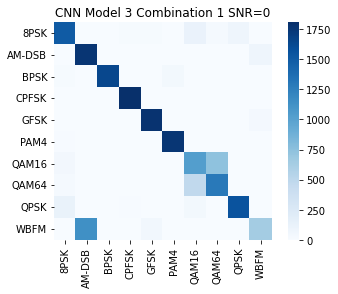

0.8208127737428619

In [ ]:
test_model("CNN_model_13.wts.h5", 1, snr="0", title="CNN Model 3 Combination 1 SNR=0")

Accuracy =  0.8520693667239182


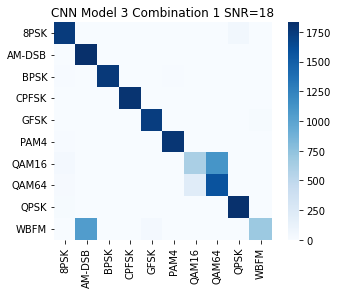

0.8520693667239182

In [ ]:
test_model("CNN_model_13.wts.h5", 1, snr="18", title="CNN Model 3 Combination 1 SNR=18")

Accuracy =  0.39208333333333334


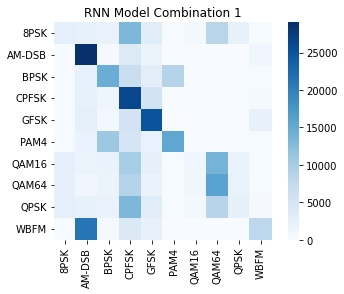

0.39208333333333334

In [ ]:
test_model("RNN_model_1.wts.h5", 1, title="RNN Model Combination 1")

Accuracy =  0.38772222222222225


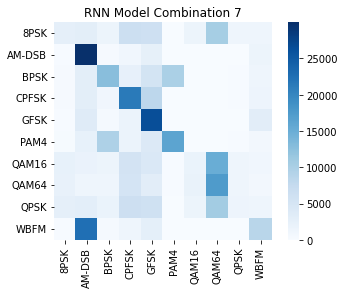

0.38772222222222225

In [ ]:
test_model("RNN_model_7.wts.h5", 7, title="RNN Model Combination 7")

Accuracy =  0.1078529379095857


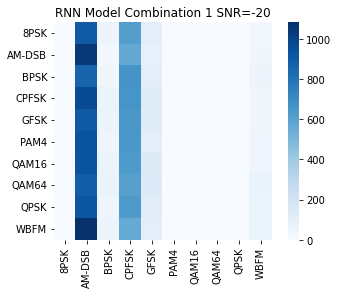

Accuracy =  0.11541016273663235


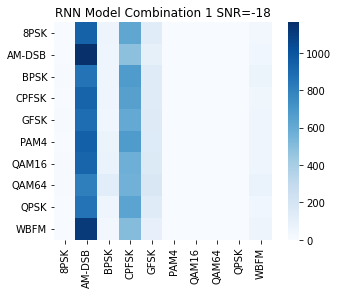

Accuracy =  0.12096685387071908


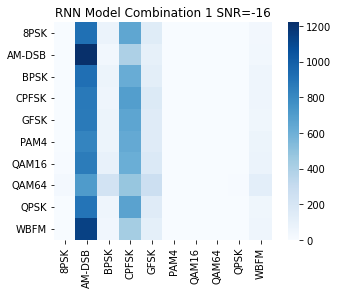

Accuracy =  0.1295448275862069


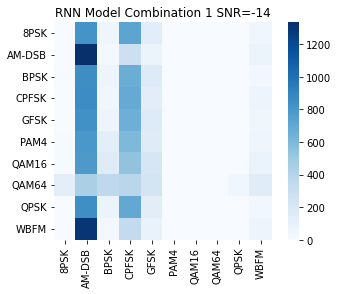

Accuracy =  0.1416047053601154


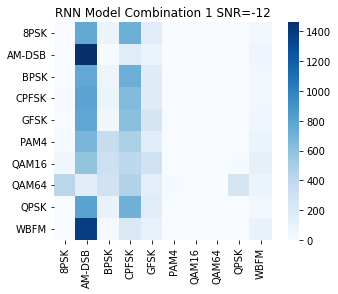

Accuracy =  0.1766714395858575


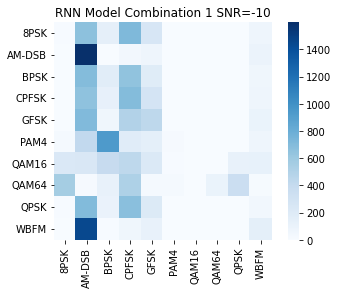

Accuracy =  0.24071688602632316


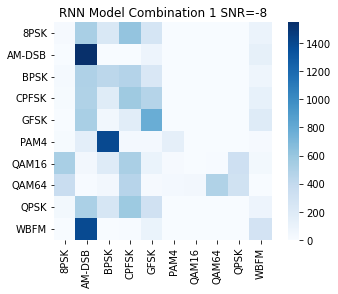

Accuracy =  0.34486793714476766


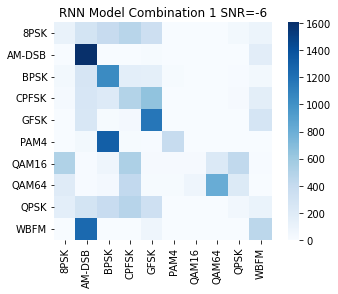

Accuracy =  0.49294209180838056


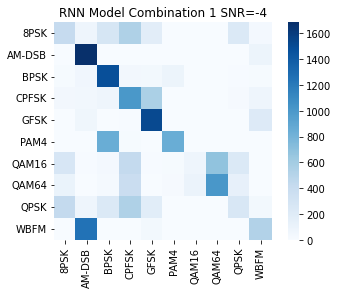

Accuracy =  0.5704268462351828


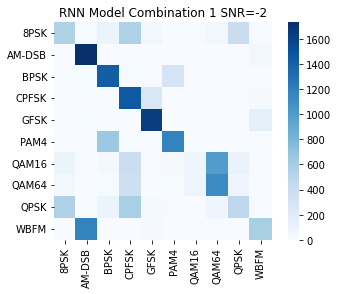

Accuracy =  0.556134612186062


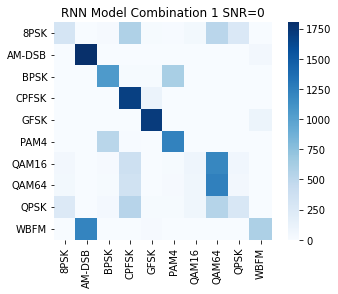

Accuracy =  0.5404669260700389


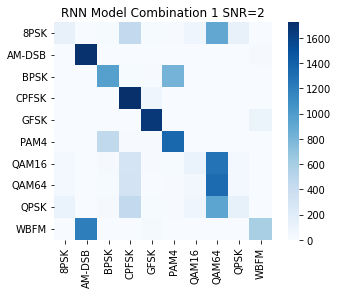

Accuracy =  0.5407353598569513


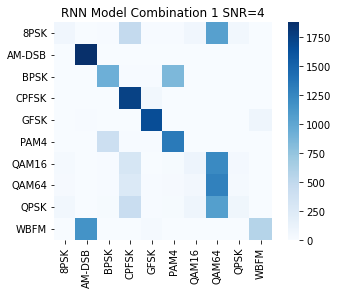

Accuracy =  0.5291153415453528


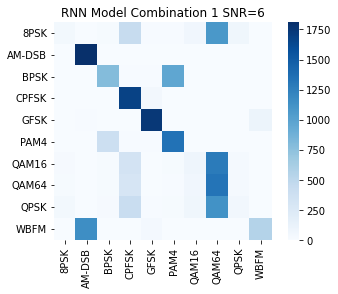

Accuracy =  0.5228914323813757


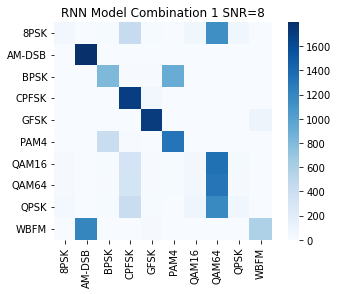

Accuracy =  0.5316724388336499


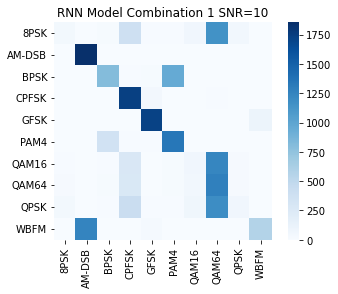

Accuracy =  0.5294215425531915


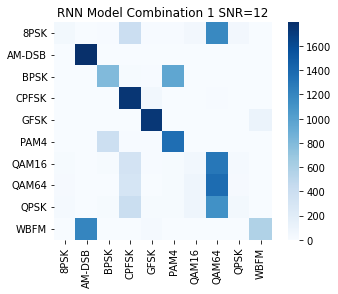

Accuracy =  0.5285801747648466


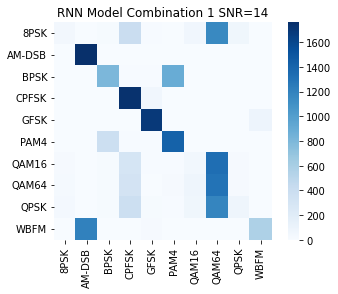

Accuracy =  0.5259052924791087


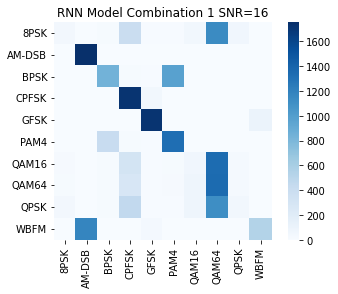

Accuracy =  0.5252368552274365


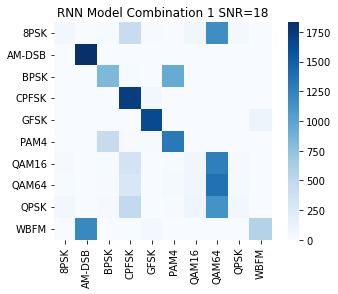

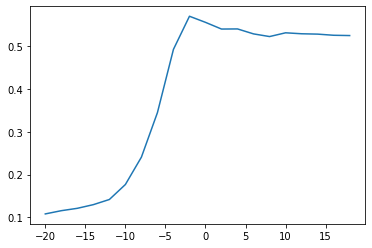

In [ ]:
plot_snrs_acc("RNN_model_1.wts.h5", "RNN Model Combination 1")

Accuracy =  0.10774186382317005


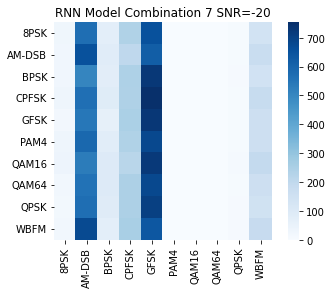

Accuracy =  0.11070519207350825


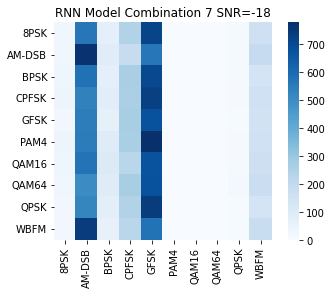

Accuracy =  0.12085673383988547


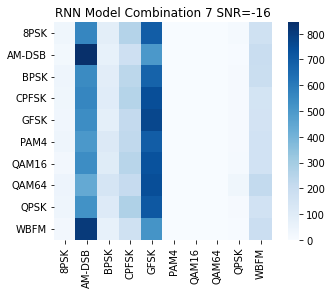

Accuracy =  0.1326344827586207


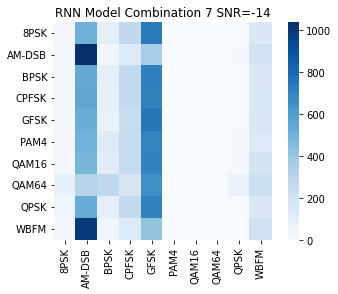

Accuracy =  0.14848518477416492


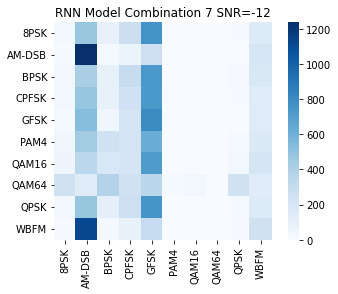

Accuracy =  0.1731468223372618


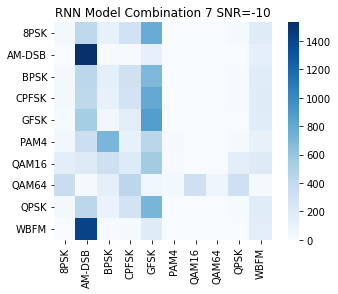

Accuracy =  0.2313637636516382


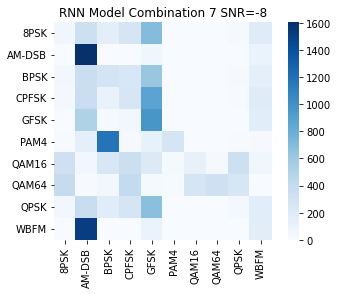

Accuracy =  0.3370110330992979


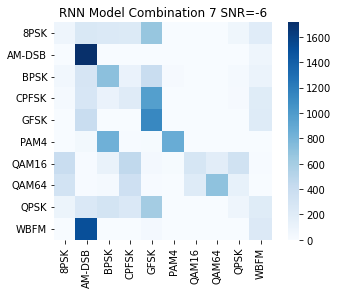

Accuracy =  0.45009447593642327


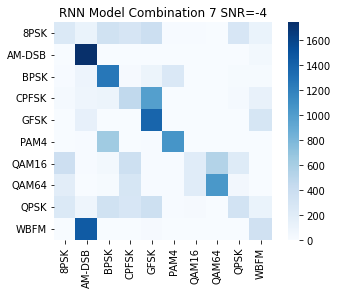

Accuracy =  0.518504090377873


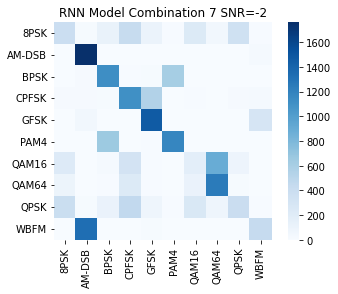

Accuracy =  0.5412208238620613


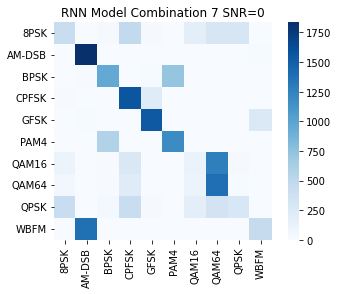

Accuracy =  0.5376320177876598


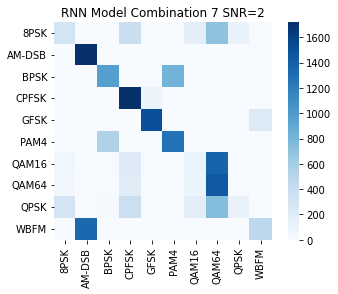

Accuracy =  0.5393942780509611


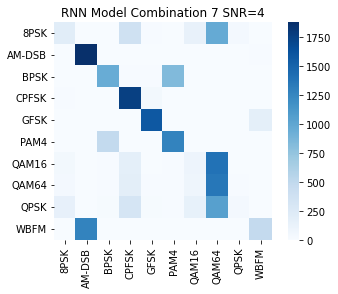

Accuracy =  0.5323628219484883


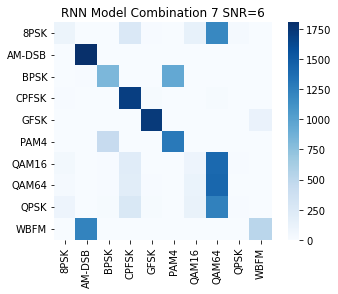

Accuracy =  0.5323924880542282


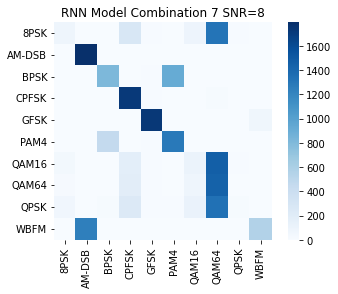

Accuracy =  0.5430119539716233


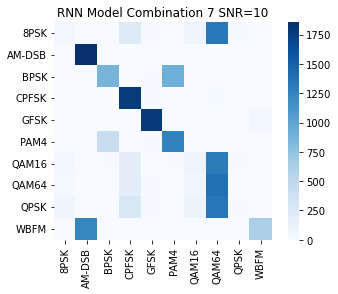

Accuracy =  0.5436613475177305


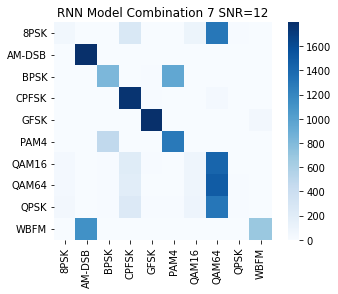

Accuracy =  0.5447765347581678


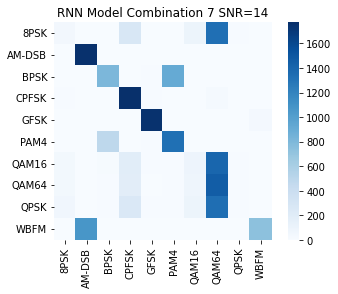

Accuracy =  0.5450696378830083


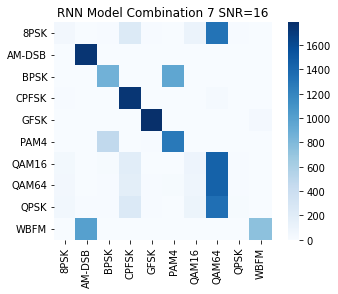

Accuracy =  0.5398637043603524


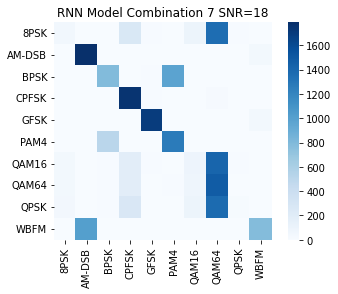

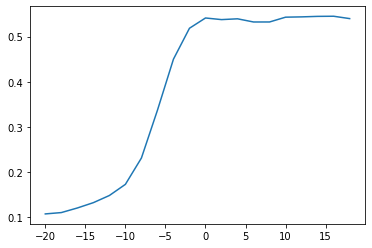

In [ ]:
plot_snrs_acc("RNN_model_7.wts.h5", "RNN Model Combination 7", 7)

Accuracy =  0.10357658558258358


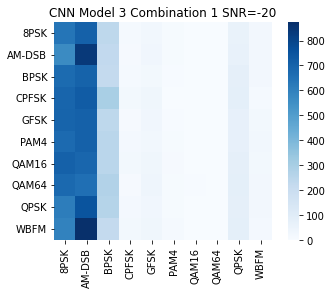

Accuracy =  0.1113694232259493


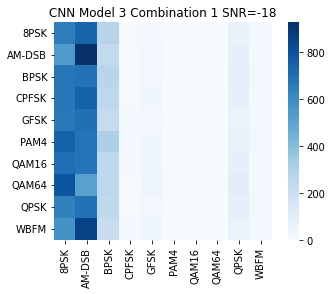

Accuracy =  0.11749807289946042


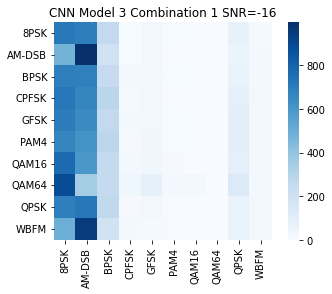

Accuracy =  0.13401379310344827


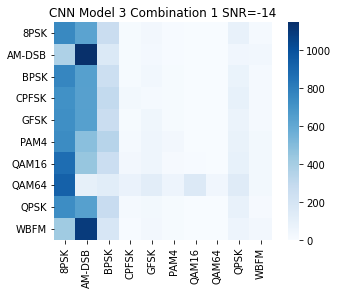

Accuracy =  0.16751747863722116


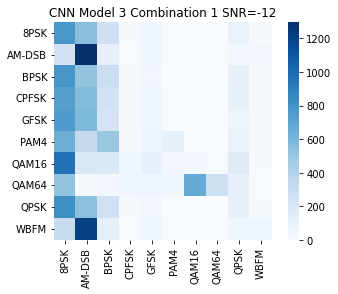

Accuracy =  0.24688842383522414


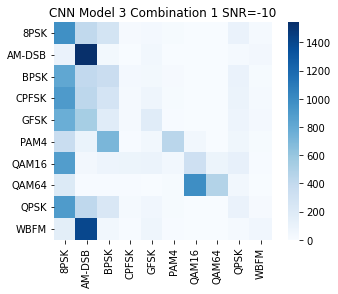

Accuracy =  0.3655558667040045


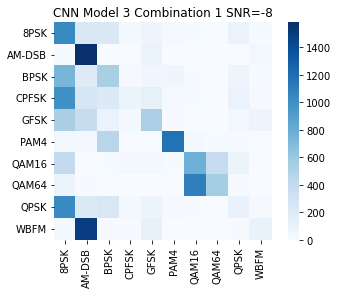

Accuracy =  0.48857684163601917


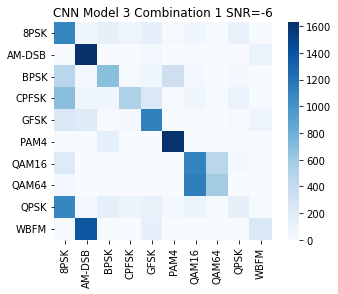

Accuracy =  0.6144270312326331


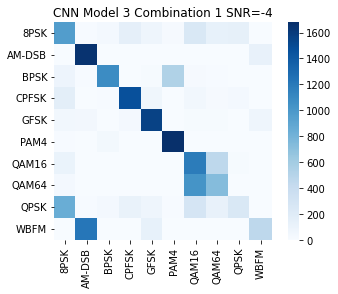

Accuracy =  0.7373810451332851


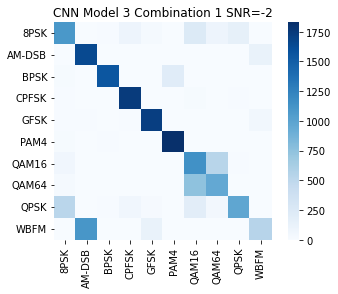

Accuracy =  0.8208127737428619


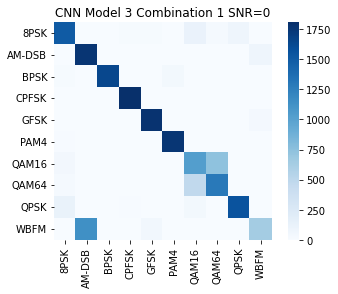

Accuracy =  0.8434685936631462


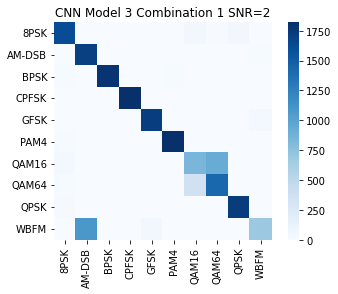

Accuracy =  0.8522574877067501


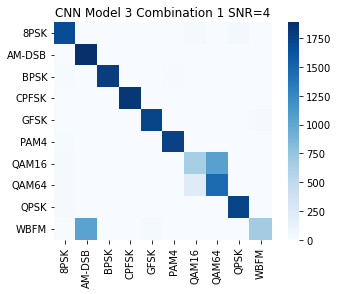

Accuracy =  0.8520716685330347


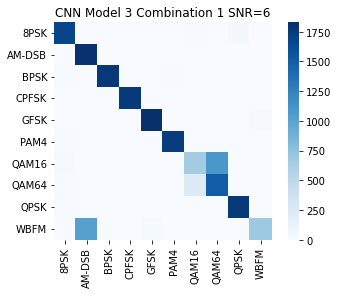

Accuracy =  0.8514279364373819


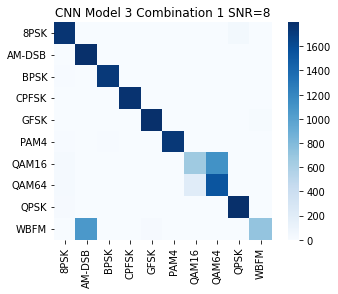

Accuracy =  0.8489554239749748


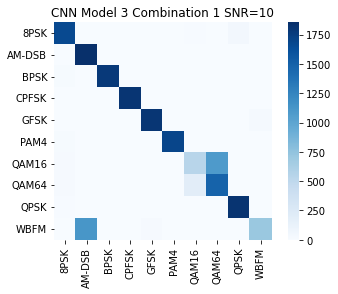

Accuracy =  0.8518395390070922


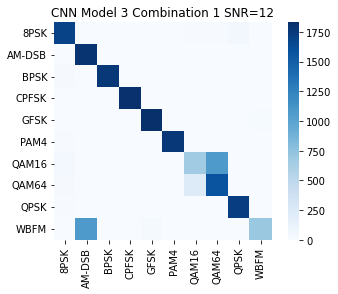

Accuracy =  0.851171592363778


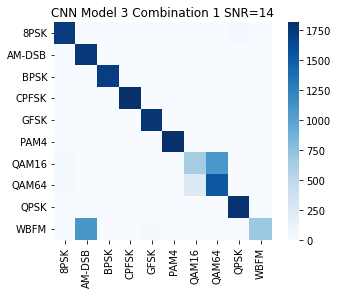

Accuracy =  0.8515320334261839


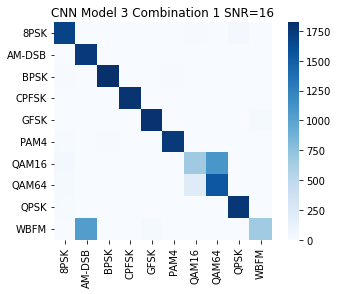

Accuracy =  0.8520693667239182


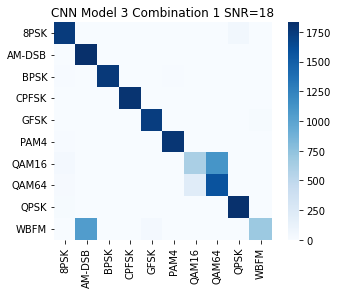

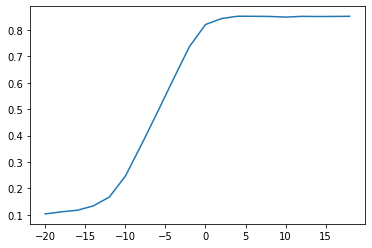

In [ ]:
plot_snrs_acc("CNN_model_13.wts.h5", "CNN Model 3 Combination 1")


Accuracy =  0.5530777777777778


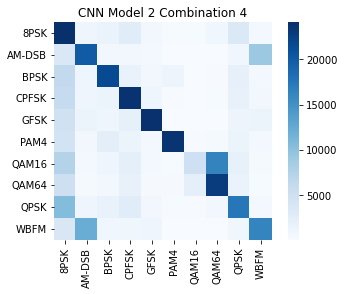

0.5530777777777778

In [ ]:
test_model("CNN_model_42.wts.h5", 4, title="CNN Model 2 Combination 4")

Accuracy =  0.10707541930467622


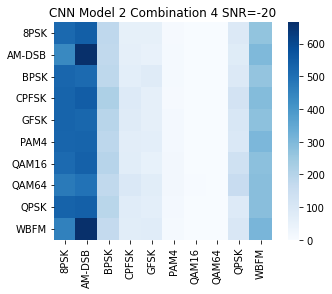

Accuracy =  0.11153548101405956


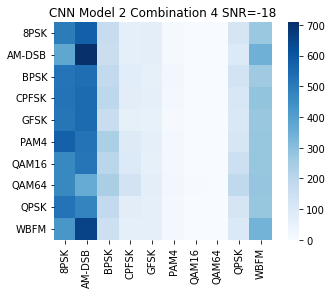

Accuracy =  0.11380905186653452


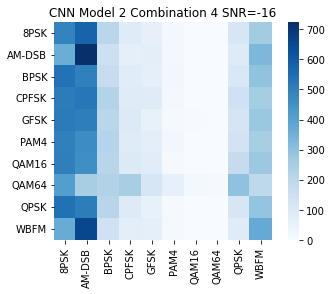

Accuracy =  0.13335172413793103


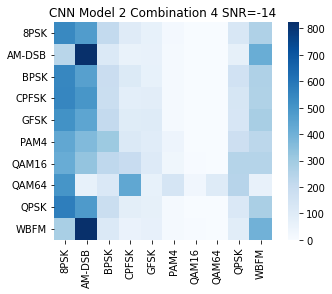

Accuracy =  0.18505160359560538


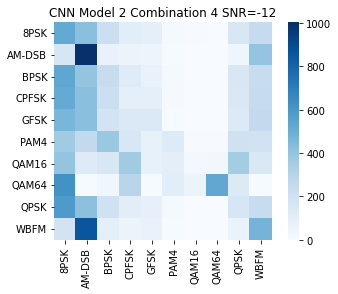

Accuracy =  0.2580129970261042


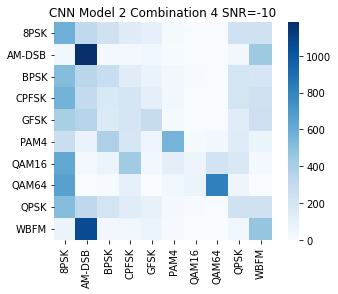

Accuracy =  0.3436572388686642


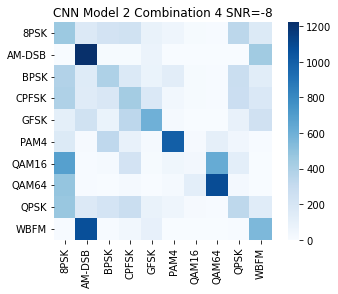

Accuracy =  0.42878635907723167


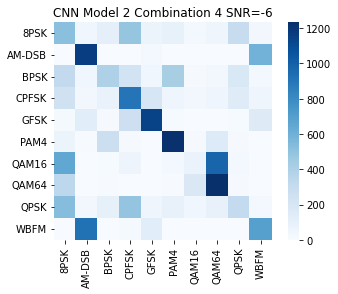

Accuracy =  0.5360120040013338


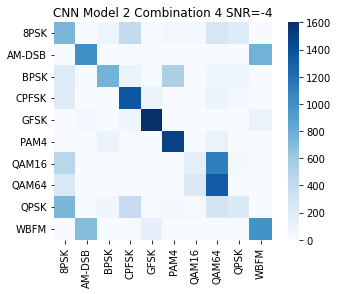

Accuracy =  0.645333630140798


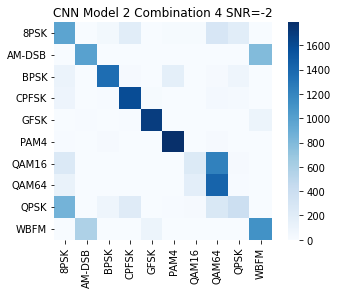

Accuracy =  0.7273936907467983


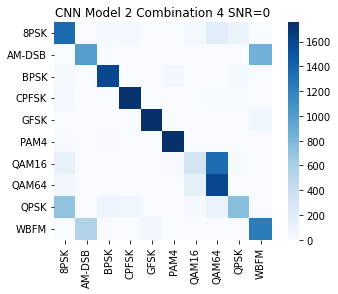

Accuracy =  0.7779321845469706


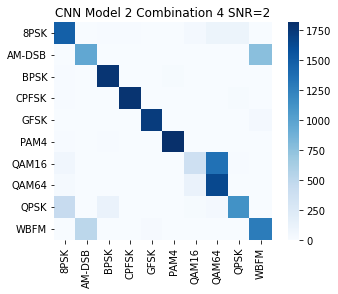

Accuracy =  0.7883325882878855


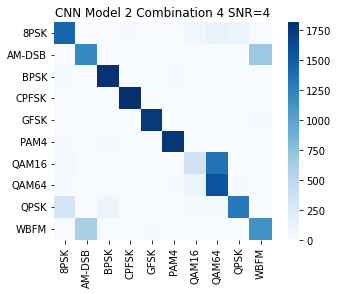

Accuracy =  0.8083426651735722


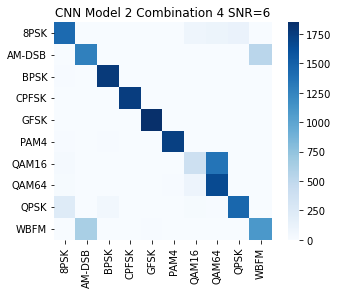

Accuracy =  0.8058673185909545


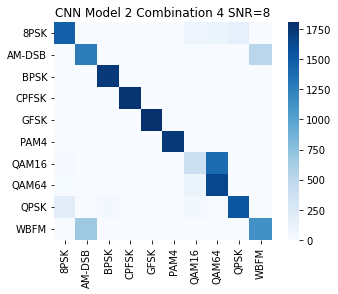

Accuracy =  0.8028153278963245


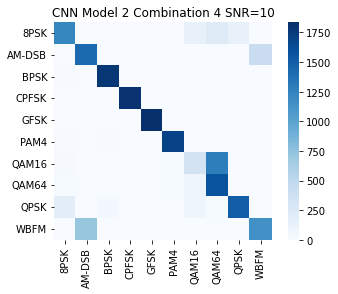

Accuracy =  0.8195921985815603


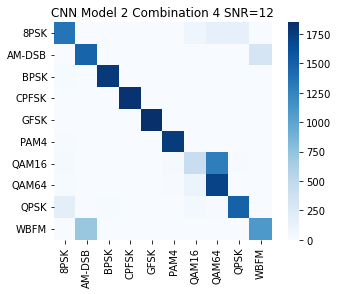

Accuracy =  0.8141036344409195


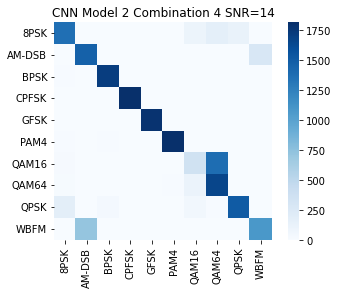

Accuracy =  0.8128133704735376


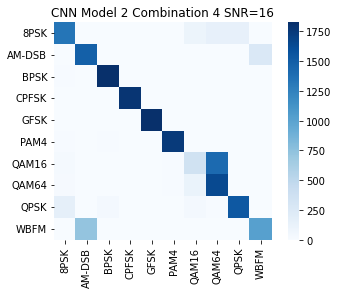

Accuracy =  0.8116239126821431


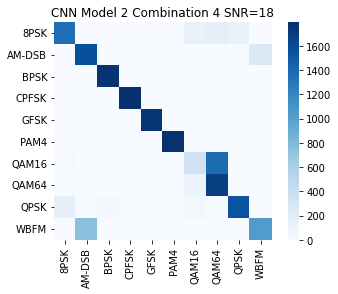

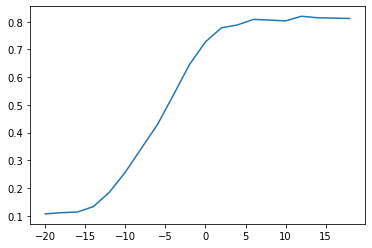

In [ ]:
plot_snrs_acc("CNN_model_42.wts.h5", "CNN Model 2 Combination 4", 4)

CNN Model 2 Combination 5 accuracy = 0.5536611111111112


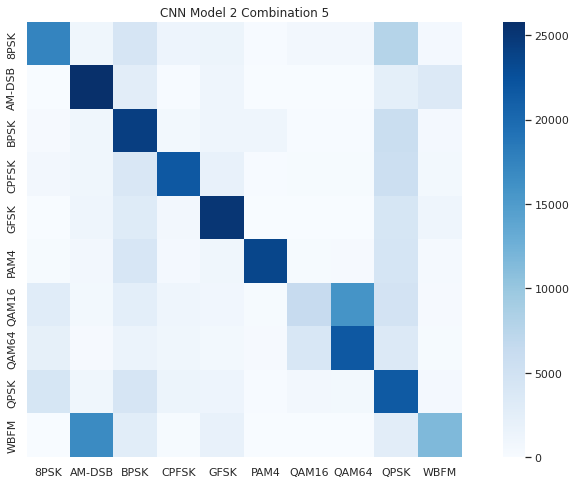

0.5536611111111112

In [ ]:
test_model("CNN_model_52.wts.h5", 5, title="CNN Model 2 Combination 5")

Accuracy =  0.10468732644673998


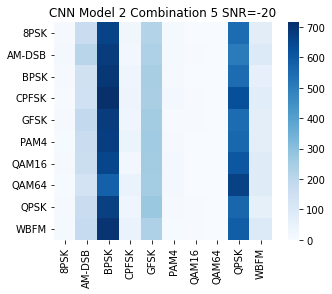

Accuracy =  0.10638768958264143


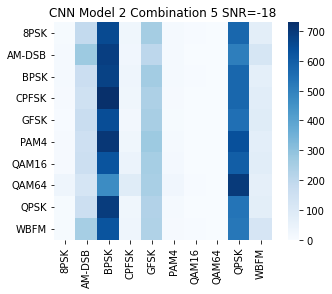

Accuracy =  0.1111111111111111


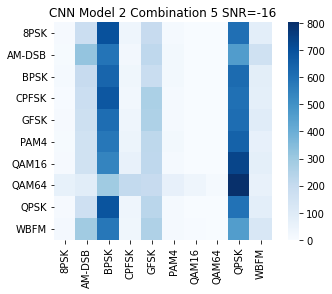

Accuracy =  0.1345655172413793


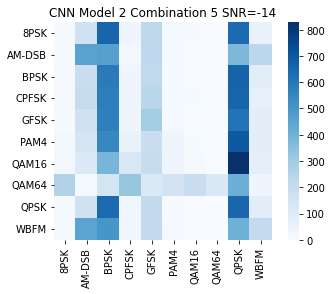

Accuracy =  0.1780601487071357


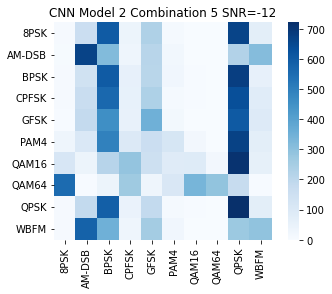

Accuracy =  0.2578477805925763


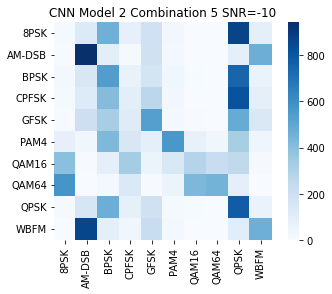

Accuracy =  0.3614113693643237


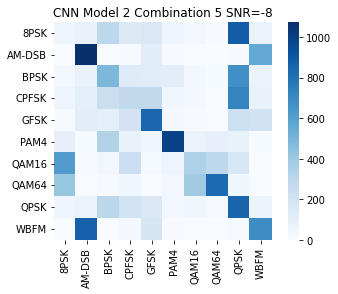

Accuracy =  0.429566477209406


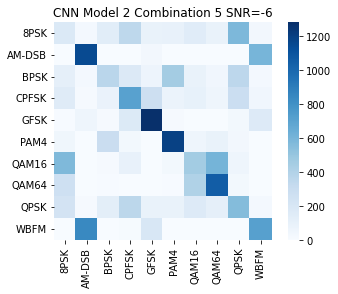

Accuracy =  0.5387907080137824


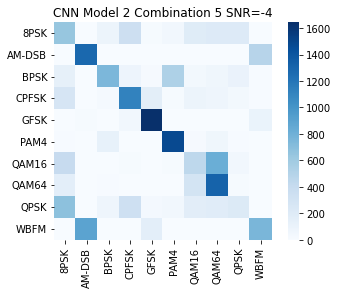

Accuracy =  0.6544048082809283


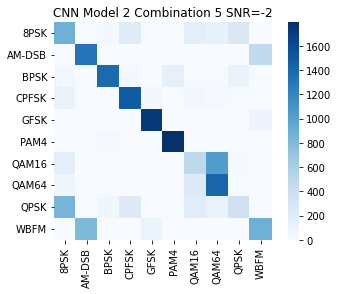

Accuracy =  0.7255086766091923


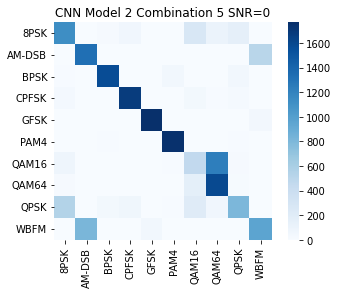

Accuracy =  0.7745414118954975


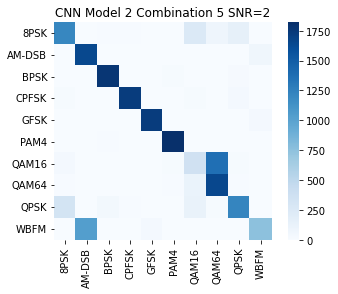

Accuracy =  0.7841975860527493


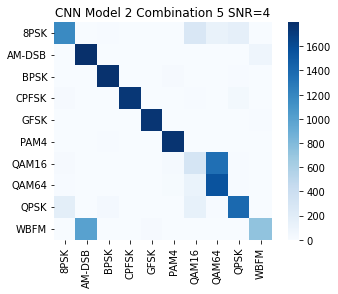

Accuracy =  0.798936170212766


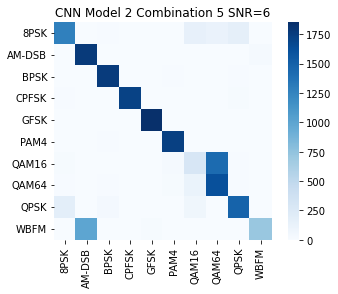

Accuracy =  0.796032892543616


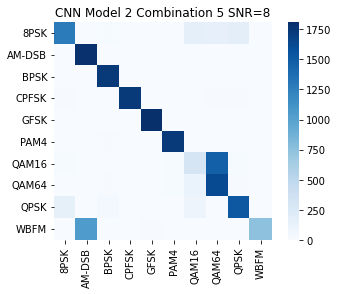

Accuracy =  0.7922578482851078


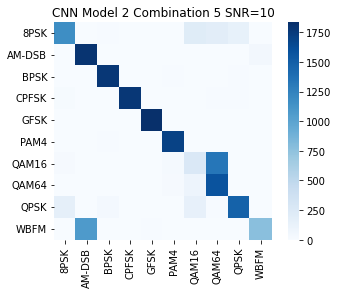

Accuracy =  0.8074024822695035


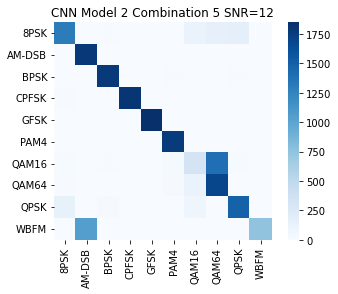

Accuracy =  0.8009127845494518


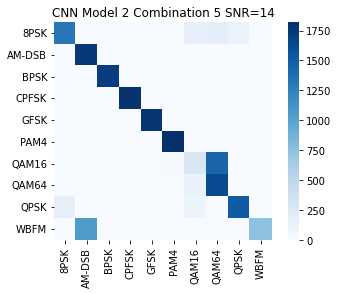

Accuracy =  0.807966573816156


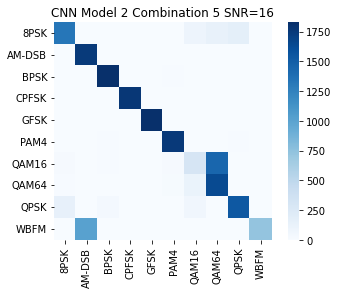

Accuracy =  0.8050861543575821


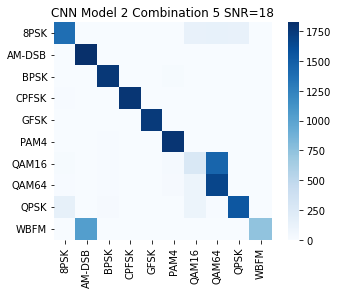

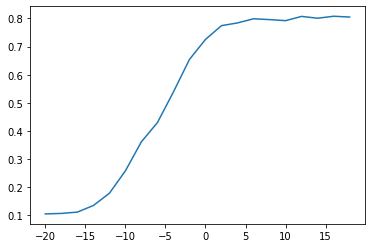

In [ ]:
plot_snrs_acc("CNN_model_52.wts.h5", "CNN Model 2 Combination 5", 5)

Accuracy =  0.4123777777777778


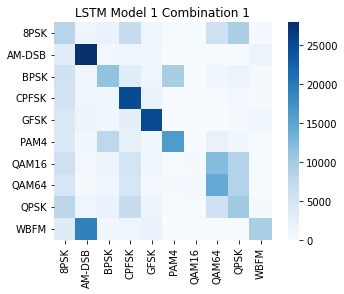

0.4123777777777778

In [ ]:
test_model("LSTM_model_1.wts.h5", 1, title="LSTM Model 1 Combination 1")

Accuracy =  0.10574253026768855


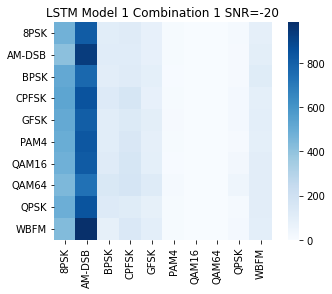

Accuracy =  0.11380493745156647


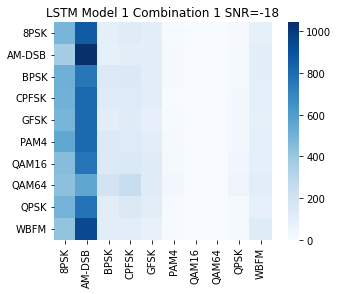

Accuracy =  0.11573615240612267


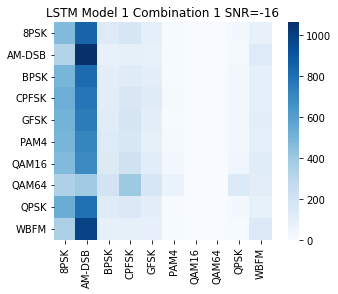

Accuracy =  0.13351724137931034


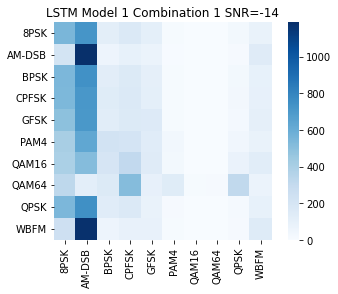

Accuracy =  0.16285650871157475


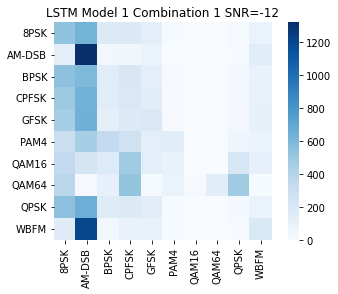

Accuracy =  0.22761317325696662


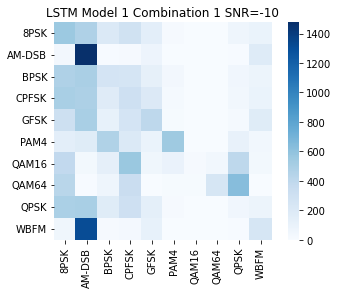

Accuracy =  0.31761411369364323


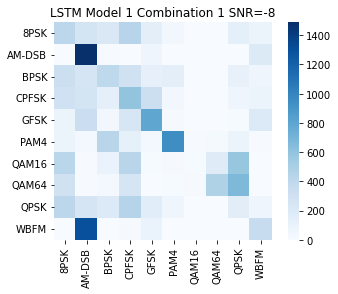

Accuracy =  0.3965229020394517


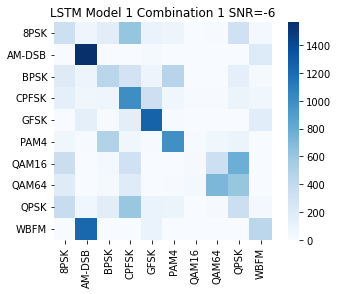

Accuracy =  0.49066355451817273


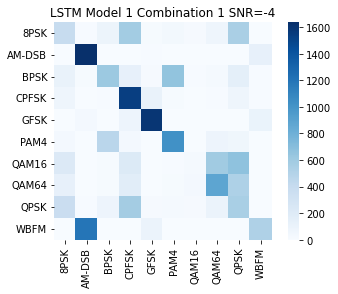

Accuracy =  0.5477767265846736


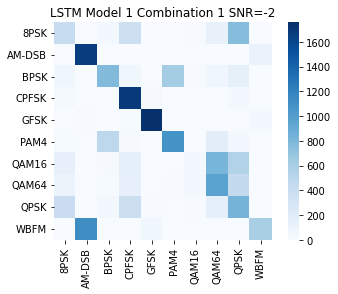

Accuracy =  0.5658368908355048


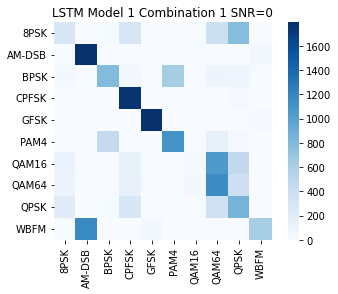

Accuracy =  0.5604224569205114


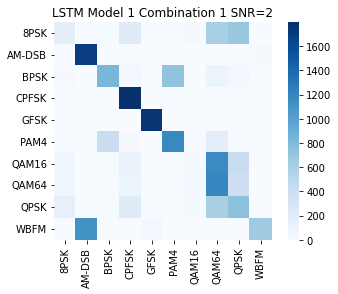

Accuracy =  0.5687863209655789


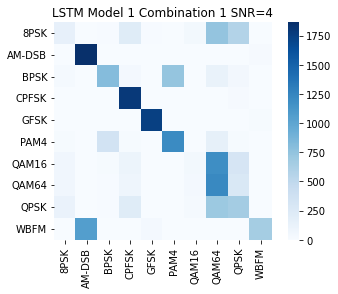

Accuracy =  0.5607502799552072


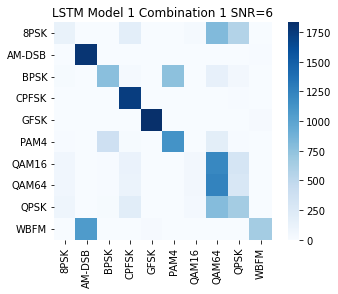

Accuracy =  0.5480053339259918


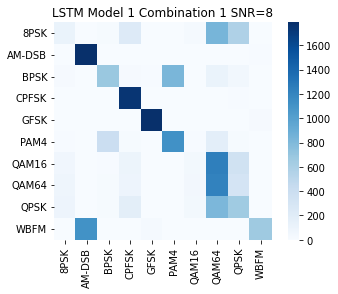

Accuracy =  0.5580382080214501


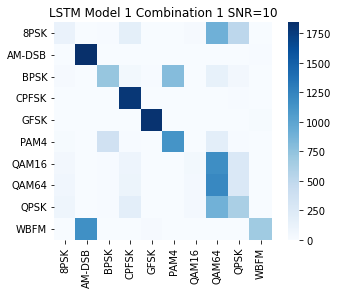

Accuracy =  0.5621675531914894


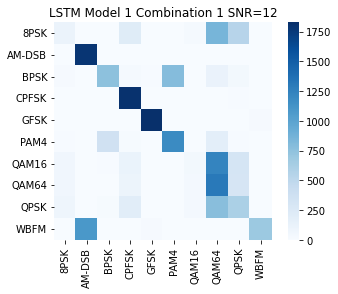

Accuracy =  0.5561863416263149


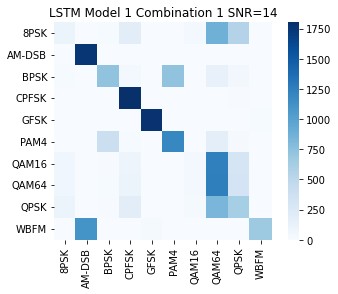

Accuracy =  0.5503621169916435


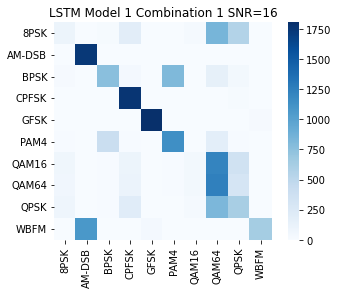

Accuracy =  0.5539919109091916


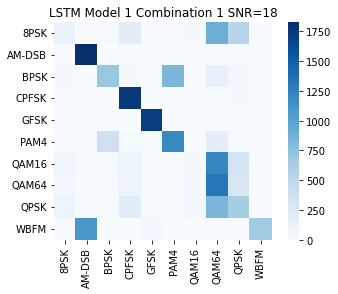

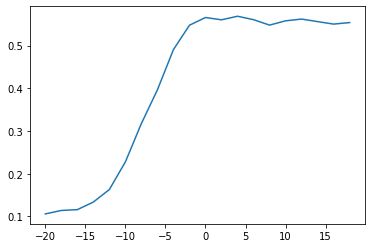

In [ ]:
plot_snrs_acc("LSTM_model_1.wts.h5", "LSTM Model 1 Combination 1")

Accuracy =  0.40426666666666666


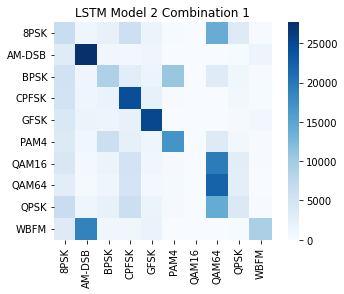

0.40426666666666666

In [ ]:
test_model("LSTM_model_12.wts.h5", 1, title="LSTM Model 2 Combination 1")

Accuracy =  0.10524269687881817


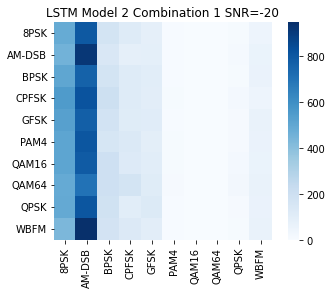

Accuracy =  0.11181224399424333


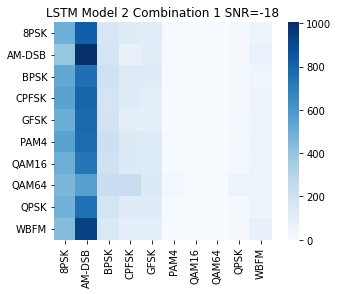

Accuracy =  0.11832397313071248


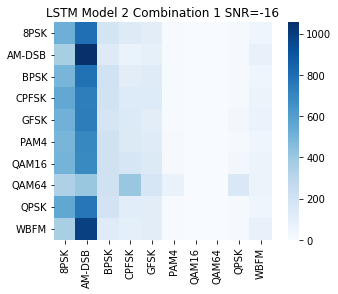

Accuracy =  0.13368275862068965


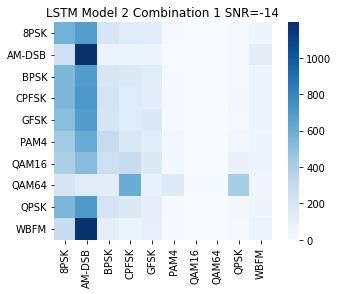

Accuracy =  0.16712906447675063


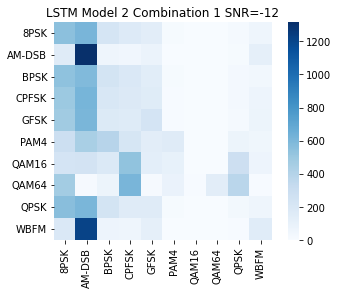

Accuracy =  0.25553475052318536


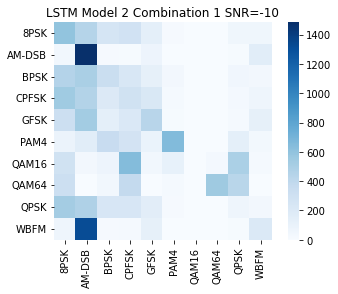

Accuracy =  0.36785214225707086


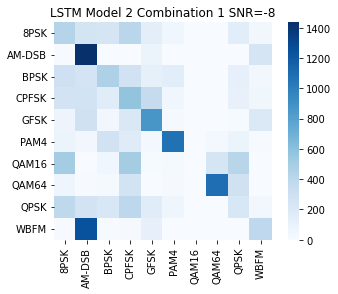

Accuracy =  0.43820349938705005


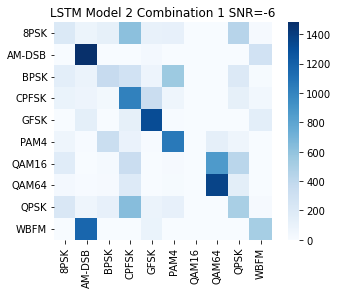

Accuracy =  0.5207847060131154


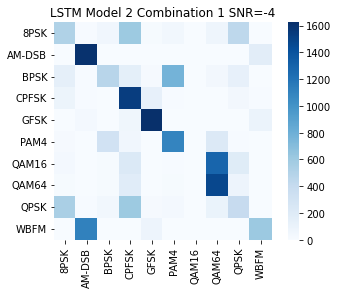

Accuracy =  0.5493349657743892


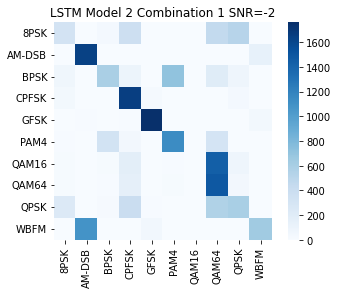

Accuracy =  0.5357321062260908


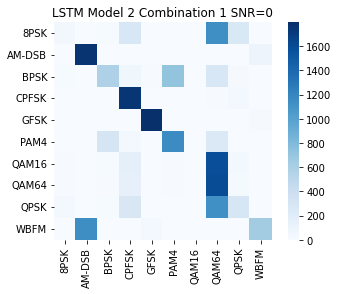

Accuracy =  0.5265703168426904


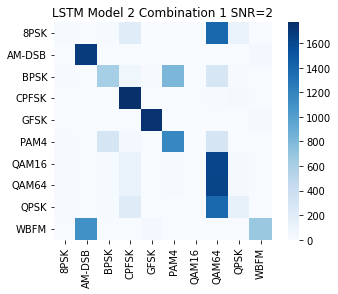

Accuracy =  0.5316830576665177


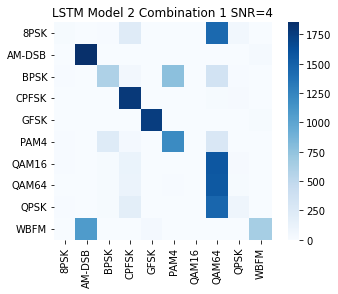

Accuracy =  0.5225643896976484


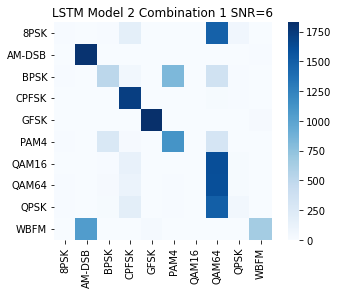

Accuracy =  0.5149461051227914


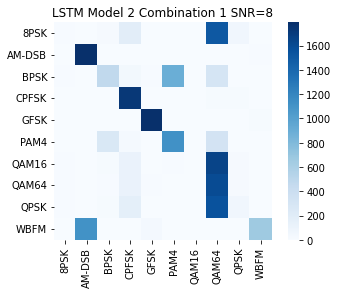

Accuracy =  0.5230141883588426


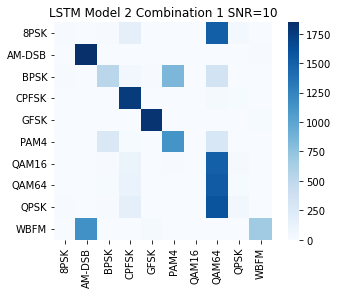

Accuracy =  0.5272606382978723


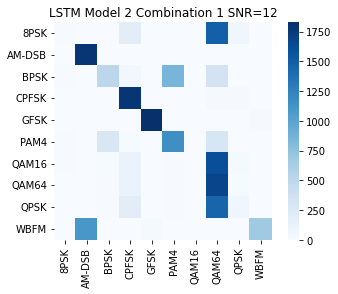

Accuracy =  0.5229031001280124


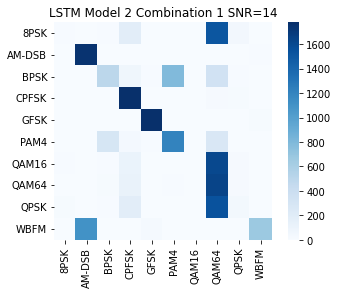

Accuracy =  0.5192200557103064


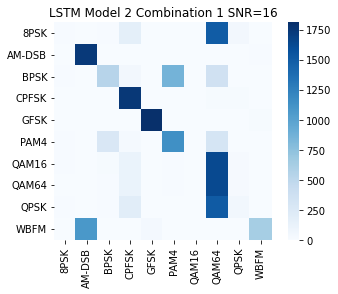

Accuracy =  0.522688237575489


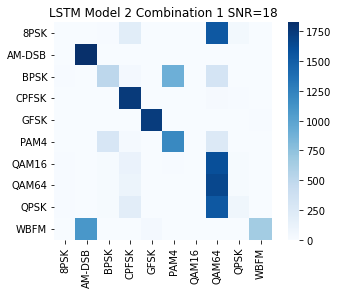

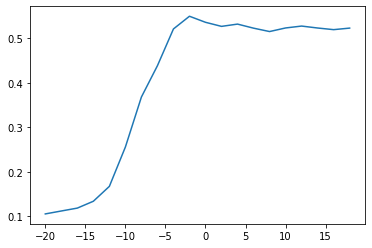

In [ ]:
plot_snrs_acc("LSTM_model_12.wts.h5", "LSTM Model 2 Combination 1")

Accuracy =  0.5348972222222222


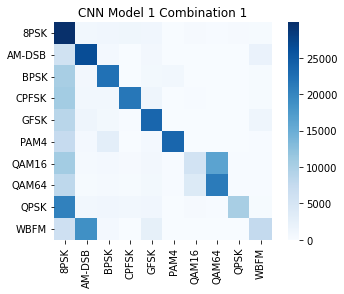

0.5348972222222222

In [ ]:
test_model("CNN_model_1.wts.h5", 1, title="CNN Model 1 Combination 1")

Accuracy =  0.10463178940353215


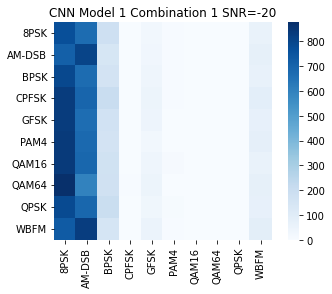

Accuracy =  0.11247647514668438


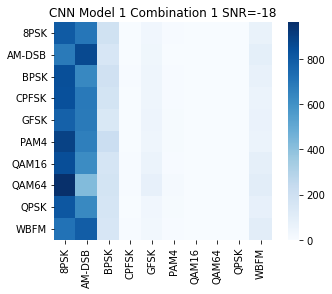

Accuracy =  0.11634181257570753


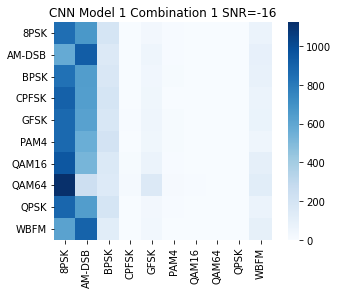

Accuracy =  0.1297103448275862


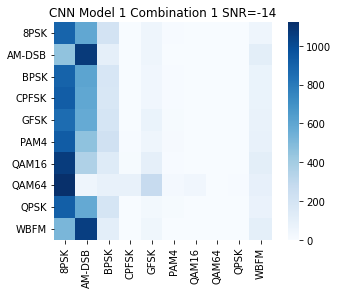

Accuracy =  0.1525357895905005


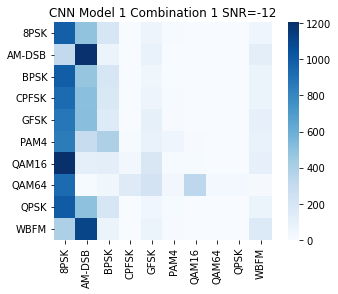

Accuracy =  0.2129639828174909


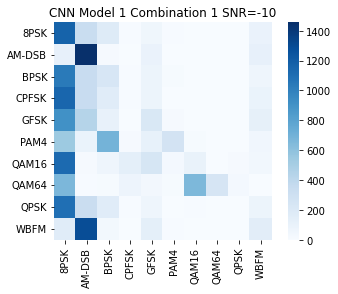

Accuracy =  0.3354242509101092


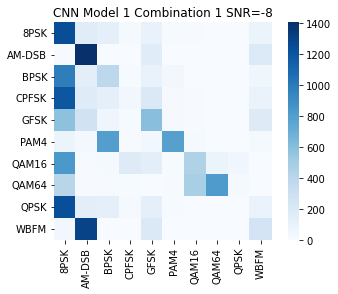

Accuracy =  0.480608492143096


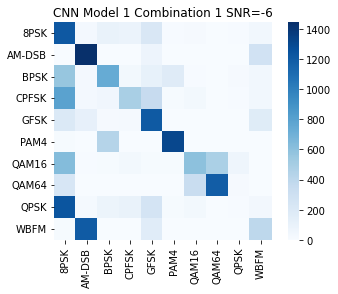

Accuracy =  0.6005335111703901


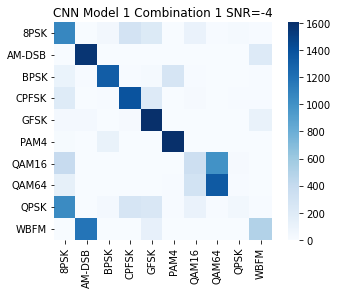

Accuracy =  0.6692080805832267


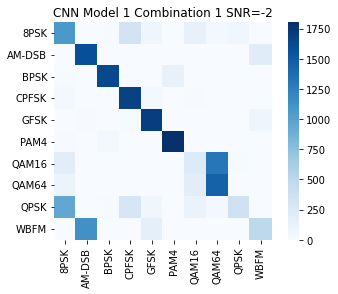

Accuracy =  0.727781781892776


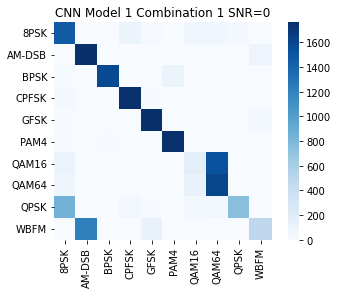

Accuracy =  0.7522512506948305


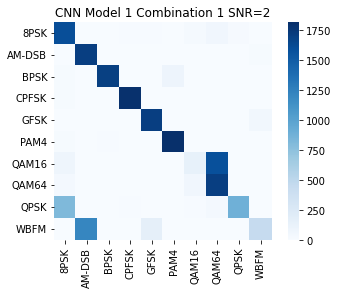

Accuracy =  0.7574318283415288


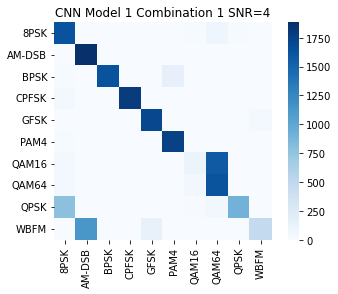

Accuracy =  0.7650055991041433


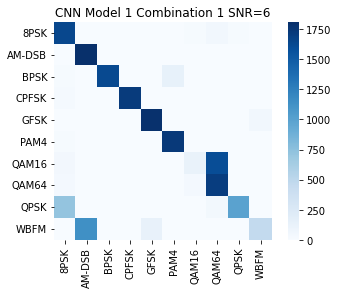

Accuracy =  0.7584731636848538


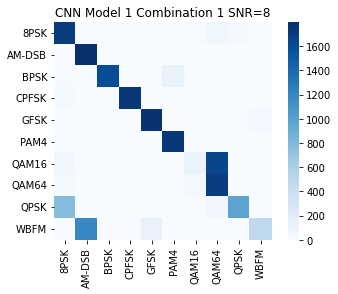

Accuracy =  0.7567310914981566


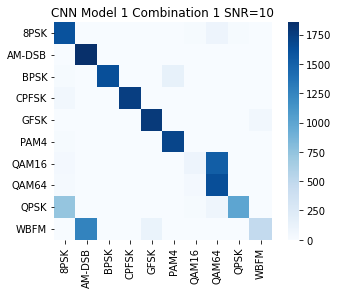

Accuracy =  0.7579233156028369


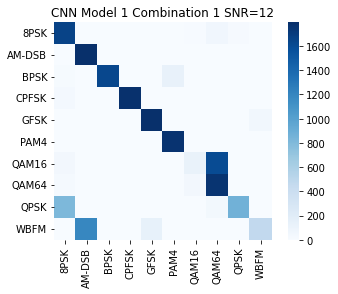

Accuracy =  0.7585573551511103


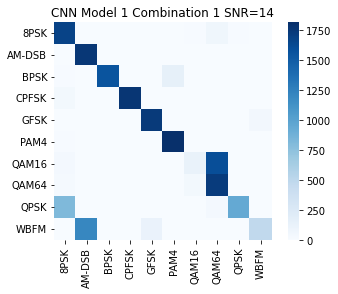

Accuracy =  0.7645125348189415


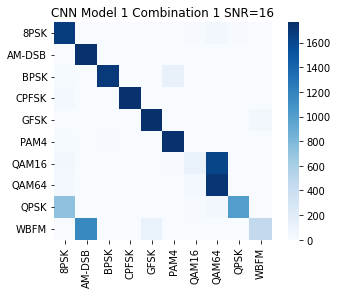

Accuracy =  0.7630339631004488


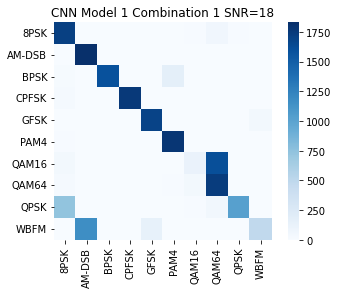

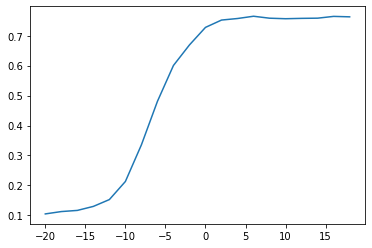

In [ ]:
plot_snrs_acc("CNN_model_1.wts.h5", "CNN Model 1 Combination 1", 1)

Accuracy =  0.5535138888888889


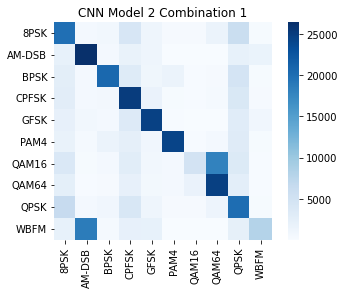

0.5535138888888889

In [ ]:
test_model("CNN_model_12.wts.h5", 1, title="CNN Model 2 Combination 1")

Accuracy =  0.10452071531711651


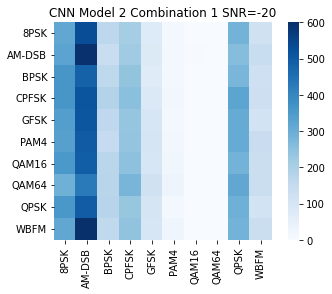

Accuracy =  0.10954278755673641


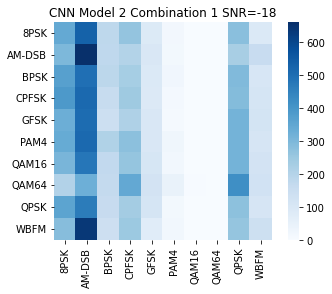

Accuracy =  0.11639687259112433


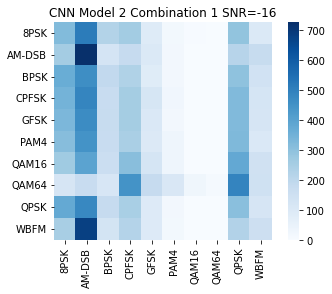

Accuracy =  0.14344827586206896


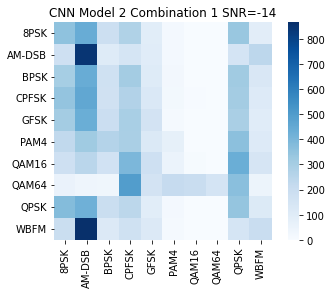

Accuracy =  0.20402840972145156


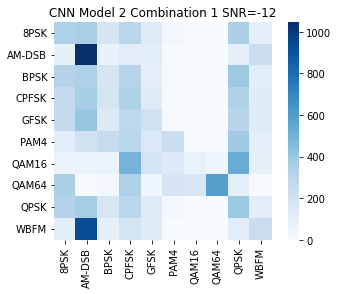

Accuracy =  0.29221279876638395


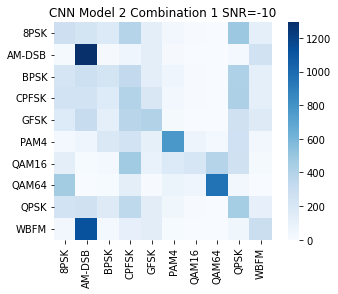

Accuracy =  0.36807616914029684


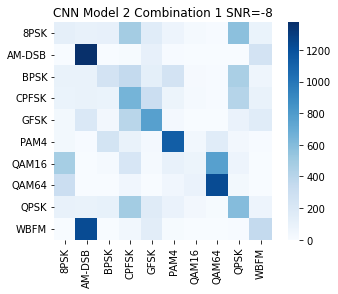

Accuracy =  0.4221553549537501


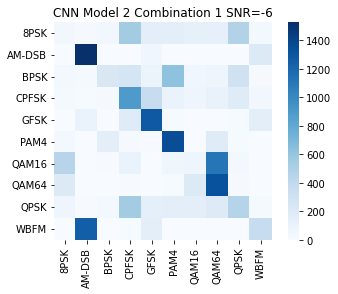

Accuracy =  0.5345115038346115


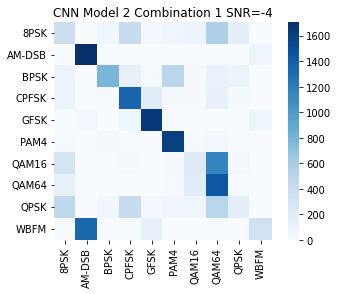

Accuracy =  0.664867271411876


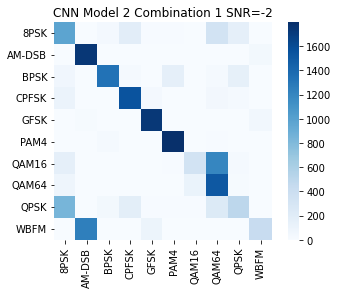

Accuracy =  0.7385928923878694


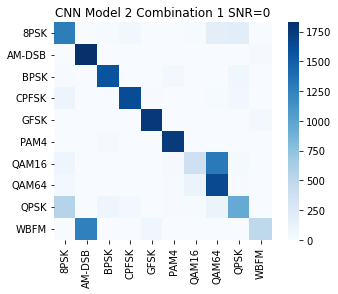

Accuracy =  0.7753752084491384


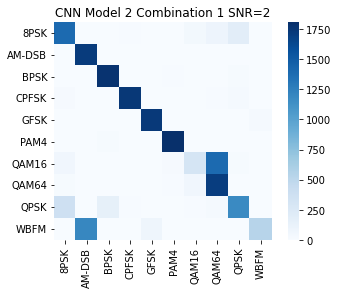

Accuracy =  0.7857621814930711


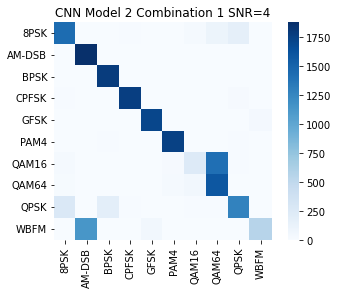

Accuracy =  0.7943449048152296


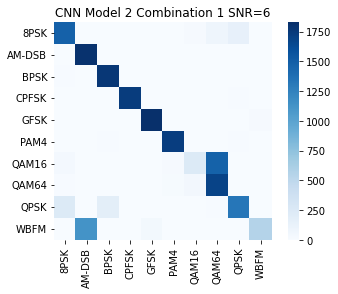

Accuracy =  0.7920324480497833


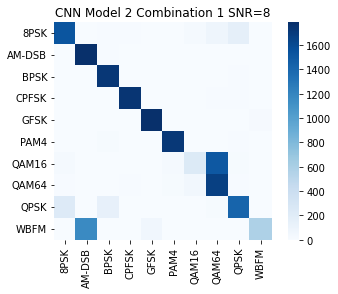

Accuracy =  0.7919226902022121


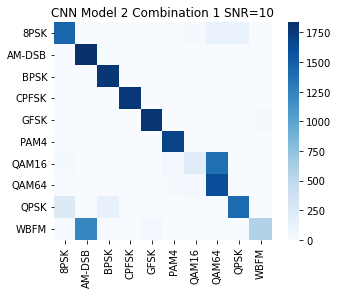

Accuracy =  0.8034685283687943


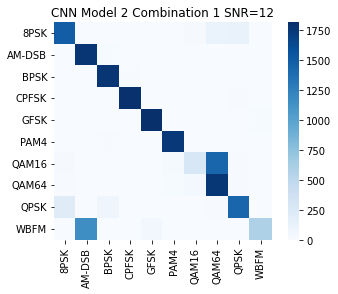

Accuracy =  0.7946234763733512


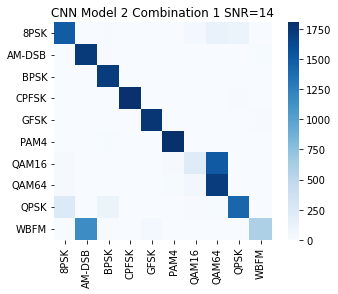

Accuracy =  0.7971030640668524


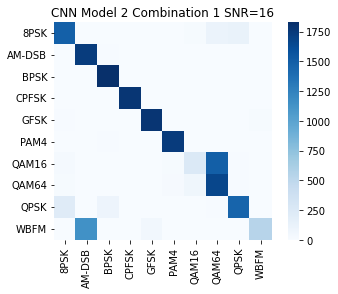

Accuracy =  0.7910133525403069


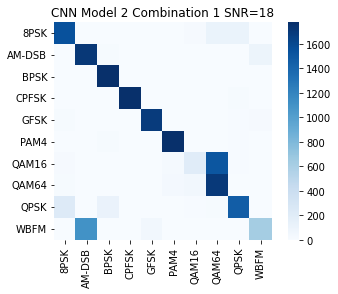

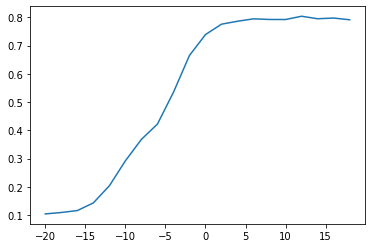

In [ ]:
plot_snrs_acc("CNN_model_12.wts.h5", "CNN Model 2 Combination 1", 1)

Accuracy =  0.10529823392202599


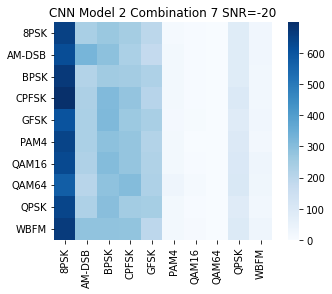

Accuracy =  0.10799291486770729


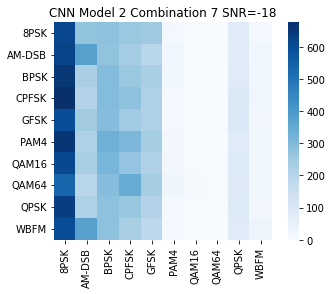

Accuracy =  0.11358881180486731


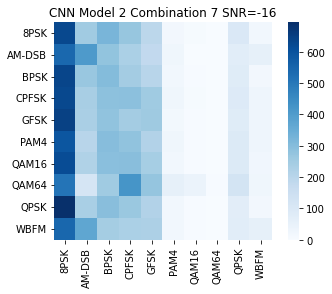

Accuracy =  0.13307586206896552


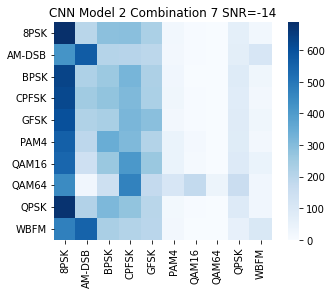

Accuracy =  0.1641882144046166


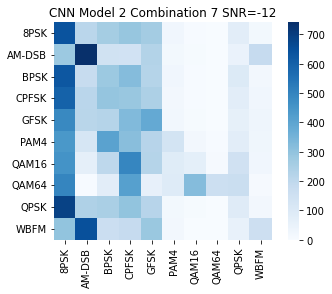

Accuracy =  0.24000440577156074


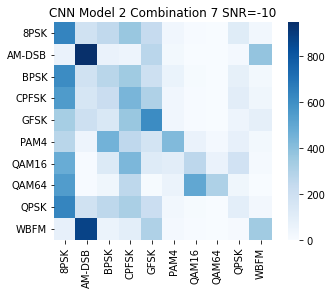

Accuracy =  0.3382805936712405


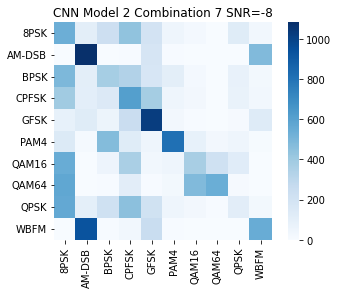

Accuracy =  0.42399420483673245


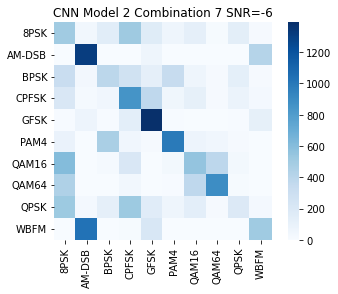

Accuracy =  0.5324552628653996


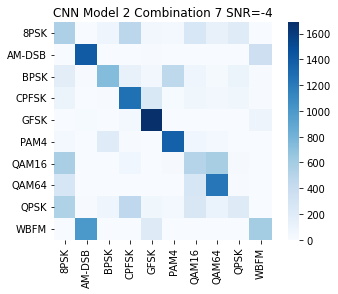

Accuracy =  0.6253547776726585


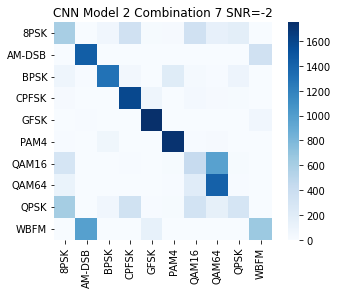

Accuracy =  0.6850917558352276


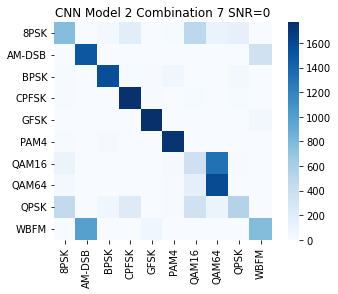

Accuracy =  0.741745414118955


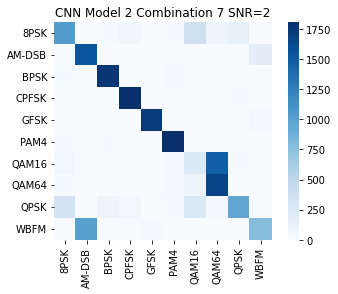

Accuracy =  0.7345216808225302


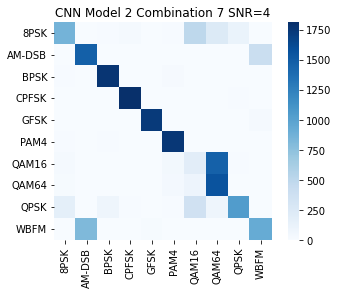

Accuracy =  0.7336506159014557


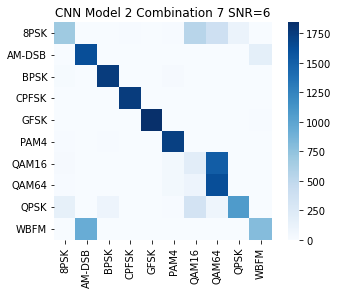

Accuracy =  0.7265807311923547


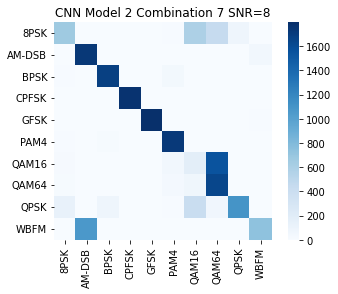

Accuracy =  0.7146128924142554


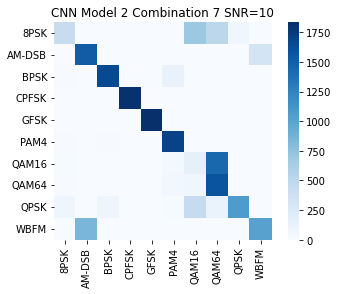

Accuracy =  0.7335438829787234


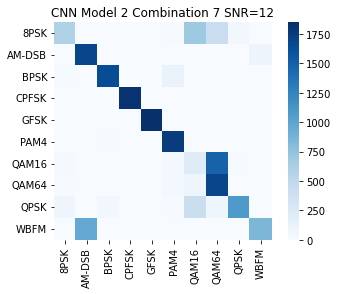

Accuracy =  0.7202649301497189


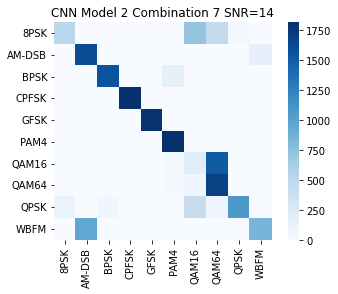

Accuracy =  0.7280222841225626


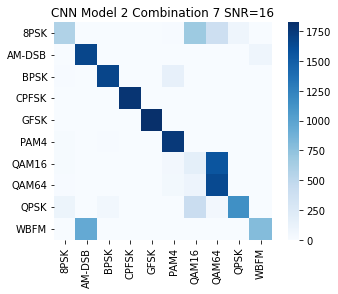

Accuracy =  0.7179899163388553


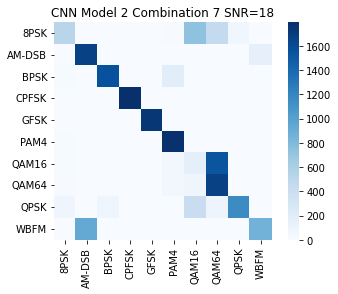

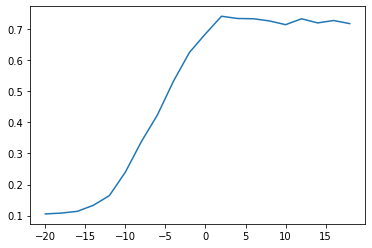

In [ ]:
plot_snrs_acc("CNN_model_72.wts.h5", "CNN Model 2 Combination 7", 7)

Accuracy =  0.10568699322448073


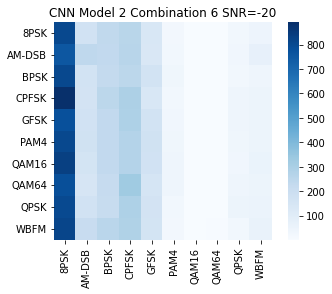

Accuracy =  0.10743938890733976


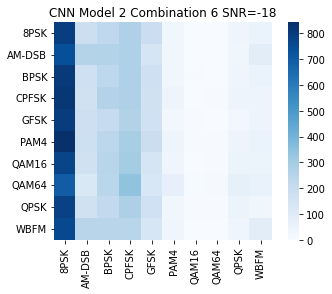

Accuracy =  0.12074661380905187


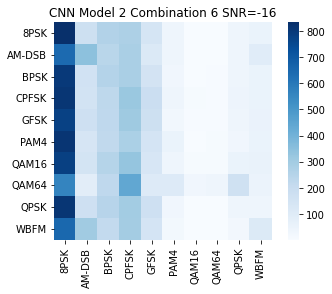

Accuracy =  0.1404137931034483


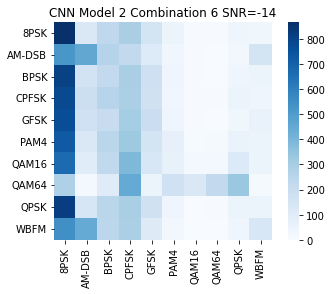

Accuracy =  0.18494062812118522


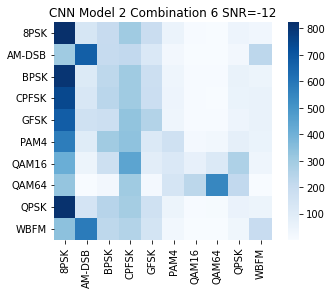

Accuracy =  0.2593898006388369


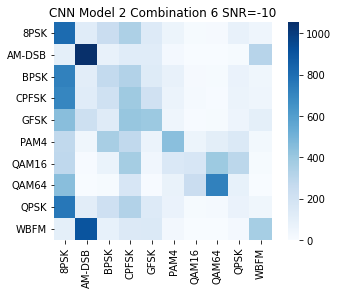

Accuracy =  0.3477457294875385


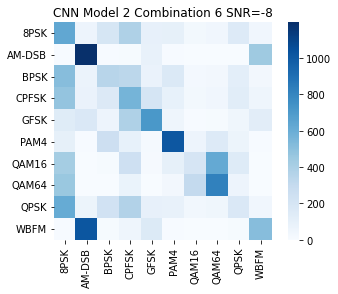

Accuracy =  0.42031650507076784


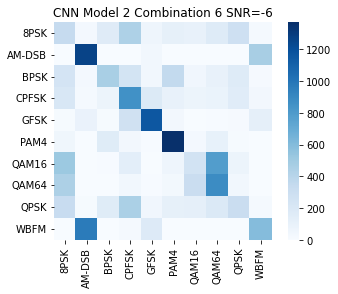

Accuracy =  0.5040569078581749


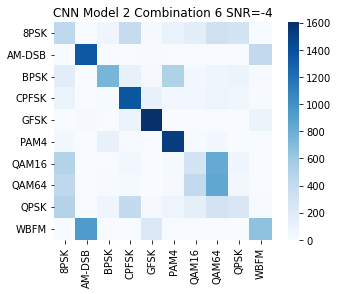

Accuracy =  0.6155601313373031


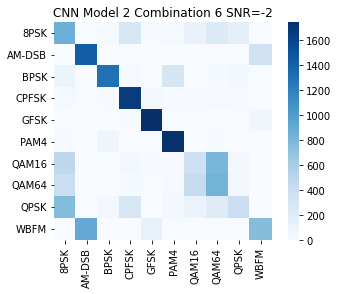

Accuracy =  0.6903587071020679


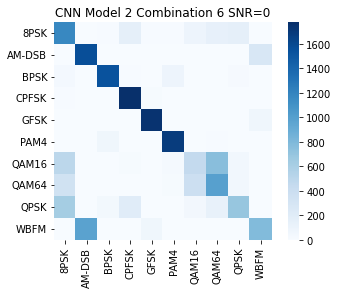

Accuracy =  0.7346303501945526


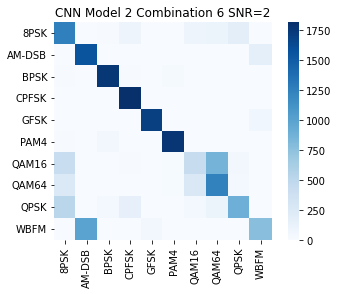

Accuracy =  0.7582141260616898


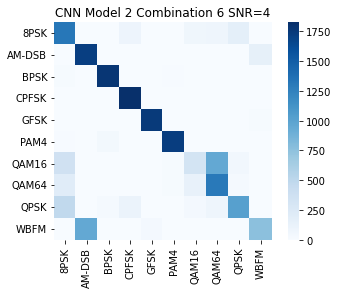

Accuracy =  0.7684210526315789


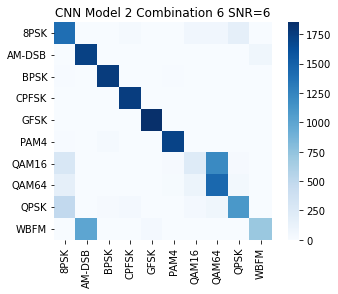

Accuracy =  0.7699188798755418


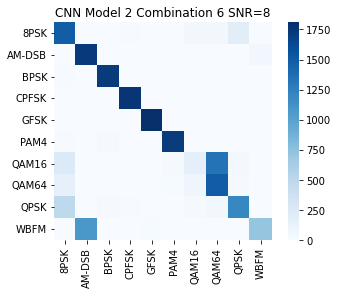

Accuracy =  0.771087029382192


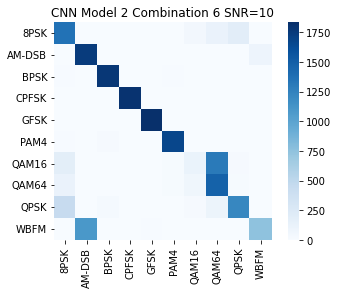

Accuracy =  0.7646276595744681


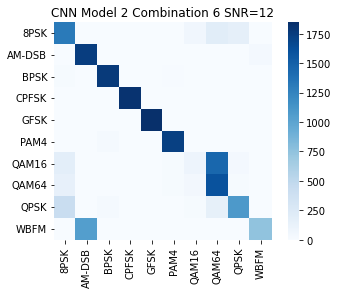

Accuracy =  0.7586130127455891


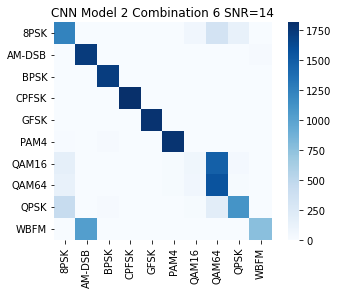

Accuracy =  0.7607242339832869


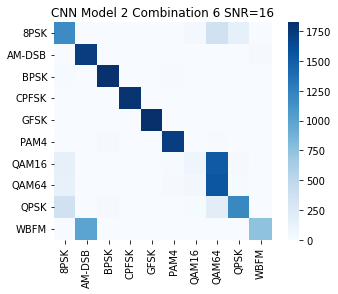

Accuracy =  0.7487395423569173


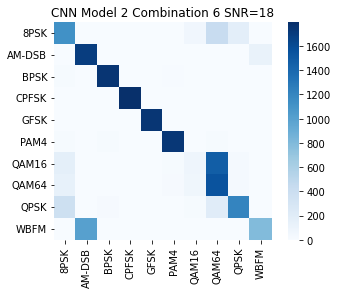

Best accuracy = 0.771087029382192 at SNR 10


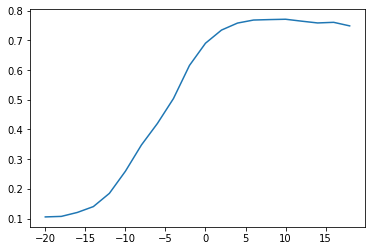

In [ ]:
plot_snrs_acc("CNN_model_62.wts.h5", "CNN Model 2 Combination 6", 6)

Accuracy =  0.5193472222222222


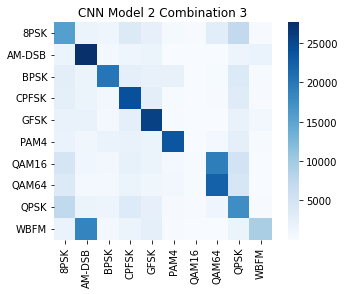

0.5193472222222222

In [ ]:
test_model("CNN_model_32.wts.h5", 3, title="CNN Model 2 Combination 3")

Accuracy =  0.105909141397312


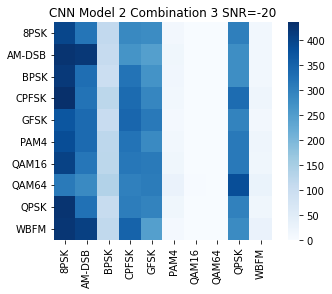

Accuracy =  0.10909996678844237


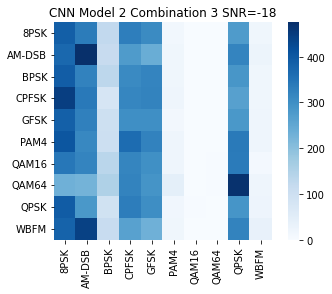

Accuracy =  0.11892963330029732


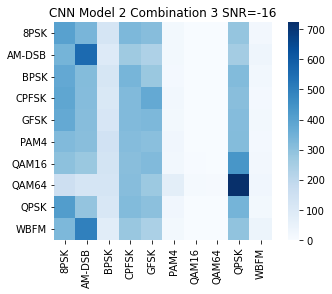

Accuracy =  0.13842758620689655


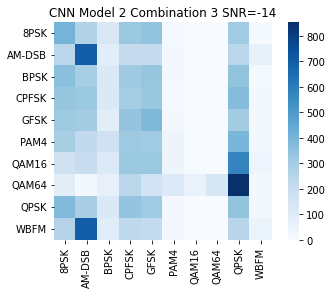

Accuracy =  0.1918765952724448


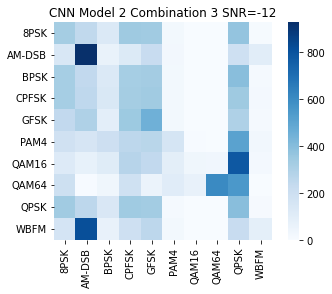

Accuracy =  0.2734331974887102


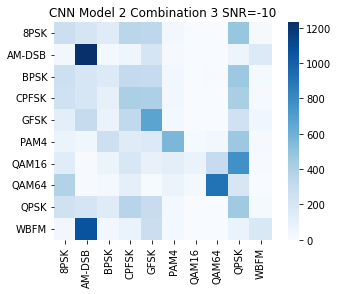

Accuracy =  0.36197143657238867


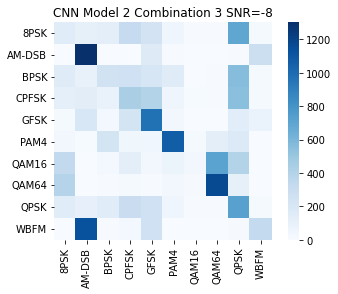

Accuracy =  0.44461161261562465


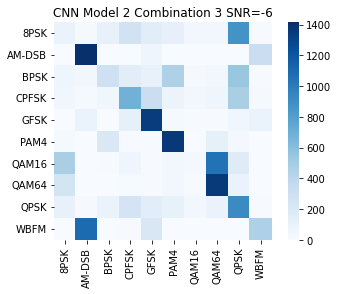

Accuracy =  0.5362898744025787


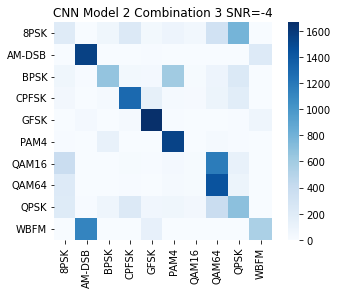

Accuracy =  0.6362068006010351


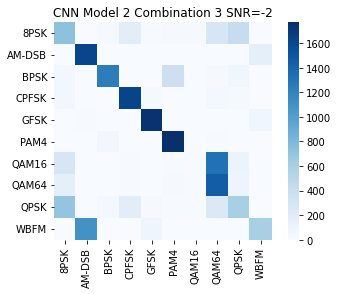

Accuracy =  0.7044963131341132


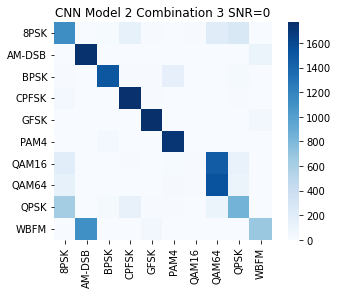

Accuracy =  0.7406892718176765


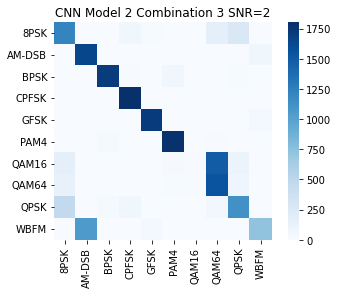

Accuracy =  0.7590523021904336


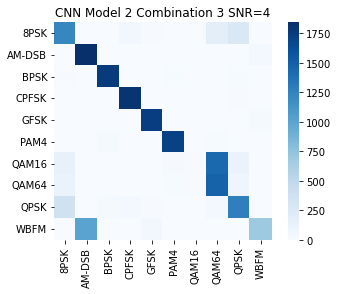

Accuracy =  0.7546472564389698


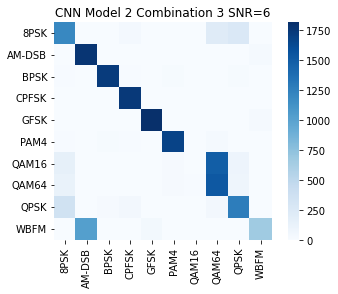

Accuracy =  0.7498610956772975


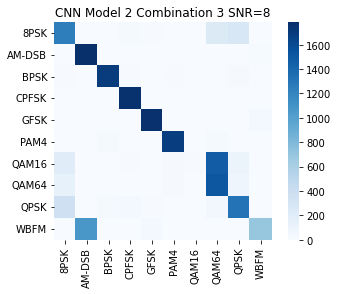

Accuracy =  0.7549994414031952


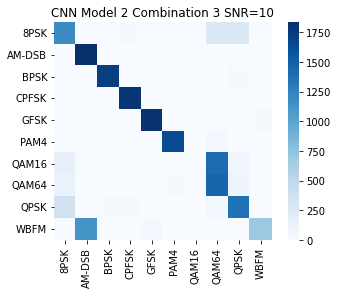

Accuracy =  0.7552083333333334


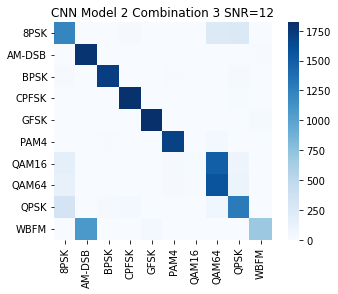

Accuracy =  0.7508209495185618


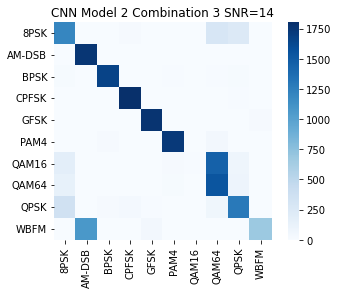

Accuracy =  0.748133704735376


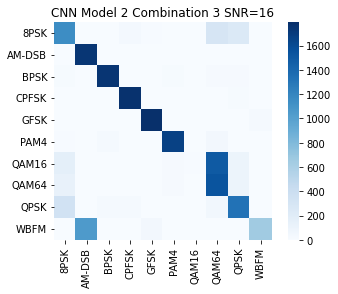

Accuracy =  0.7502908748407114


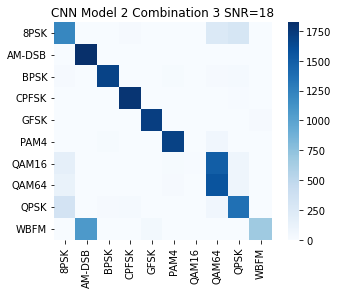

Best accuracy = 0.7590523021904336 at SNR 4


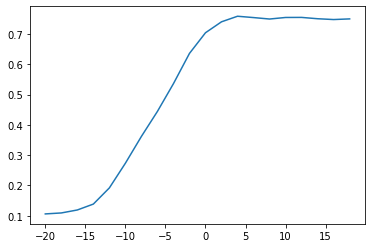

In [ ]:
plot_snrs_acc("CNN_model_32.wts.h5", "CNN Model 2 Combination 3", 3)

Accuracy =  0.10357658558258358


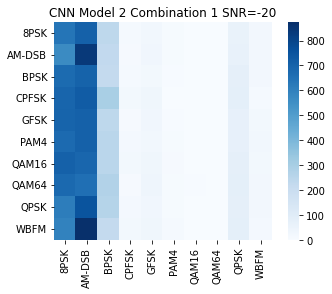

Accuracy =  0.1113694232259493


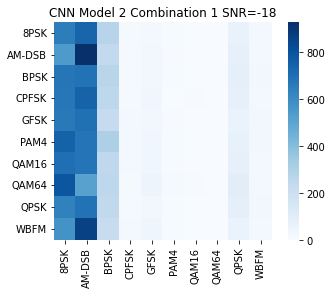

Accuracy =  0.11749807289946042


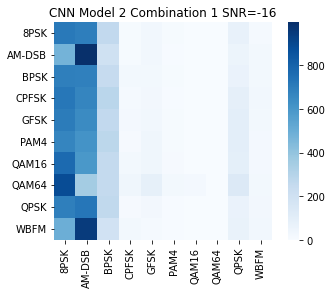

Accuracy =  0.13401379310344827


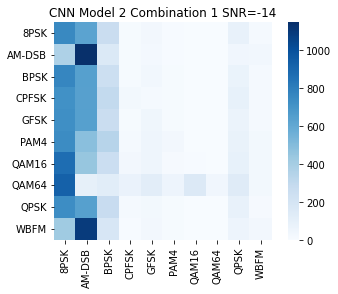

Accuracy =  0.16751747863722116


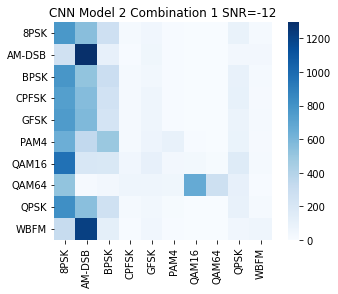

Accuracy =  0.24688842383522414


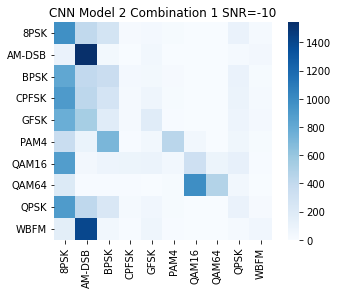

Accuracy =  0.3655558667040045


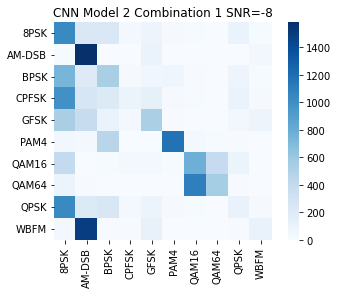

Accuracy =  0.48857684163601917


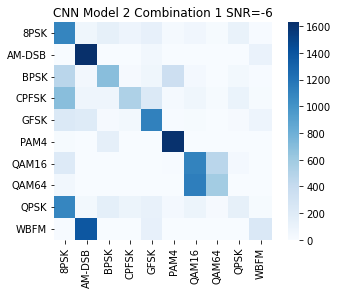

Accuracy =  0.6144270312326331


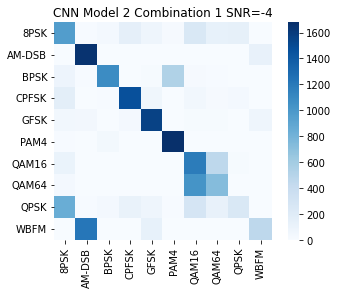

Accuracy =  0.7373810451332851


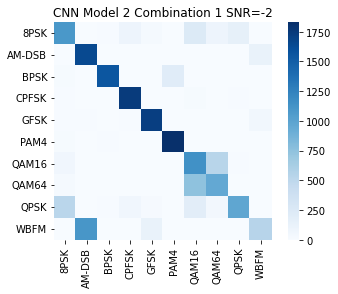

Accuracy =  0.8208127737428619


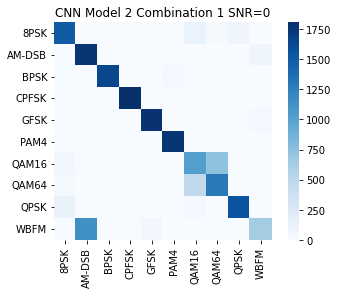

Accuracy =  0.8434685936631462


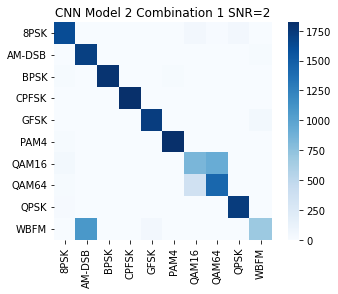

Accuracy =  0.8522574877067501


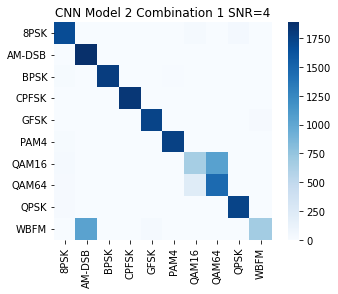

Accuracy =  0.8520716685330347


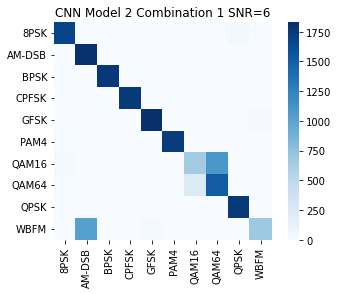

Accuracy =  0.8514279364373819


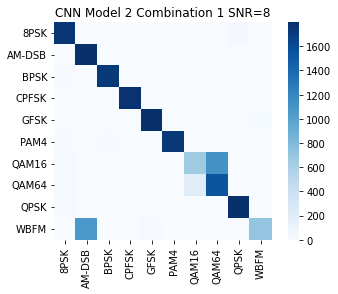

Accuracy =  0.8489554239749748


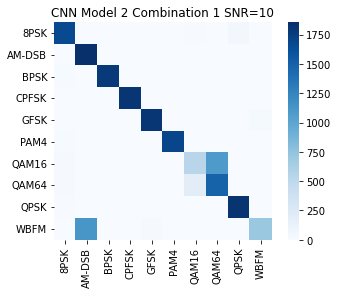

Accuracy =  0.8518395390070922


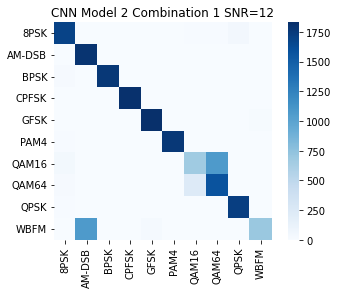

Accuracy =  0.851171592363778


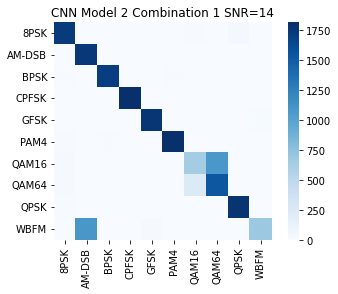

Accuracy =  0.8515320334261839


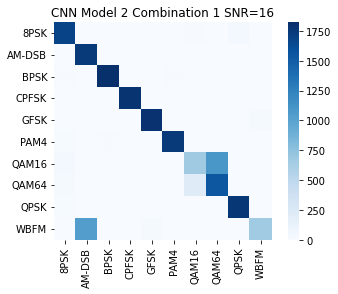

Accuracy =  0.8520693667239182


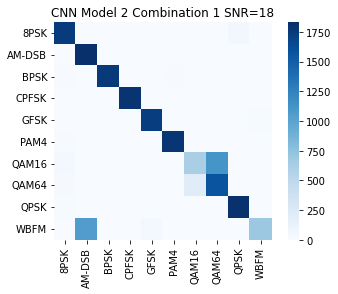

Best accuracy = 0.8522574877067501 at SNR 4


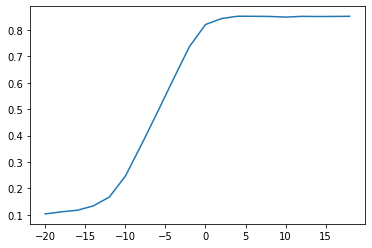

In [ ]:
plot_snrs_acc("CNN_model_13.wts.h5", "CNN Model 2 Combination 1", 1)

Accuracy =  0.09896701099633455


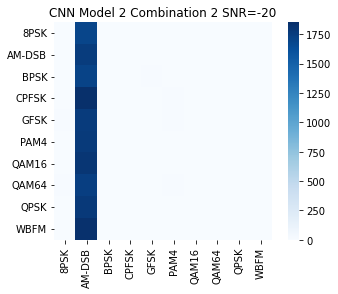

Accuracy =  0.10301118122439942


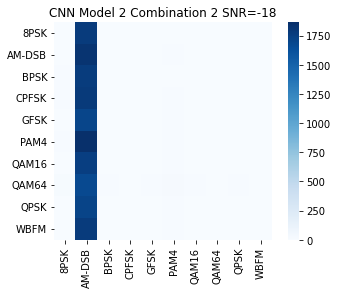

Accuracy =  0.10169584847483758


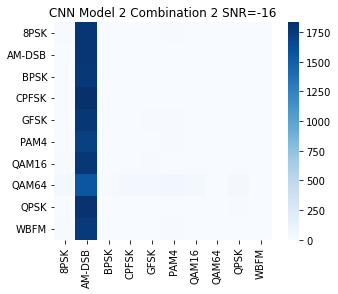

Accuracy =  0.10206896551724139


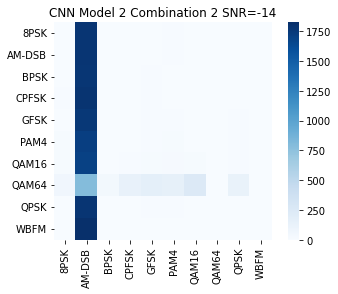

Accuracy =  0.10969925646432138


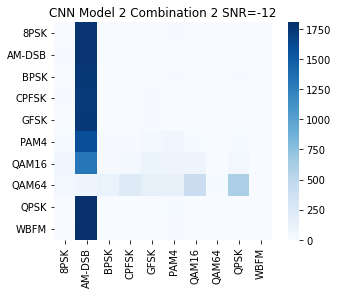

Accuracy =  0.14522524507104306


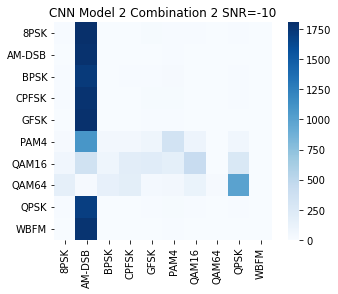

Accuracy =  0.1719966395967516


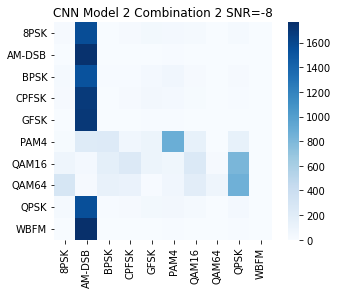

Accuracy =  0.19274490137077901


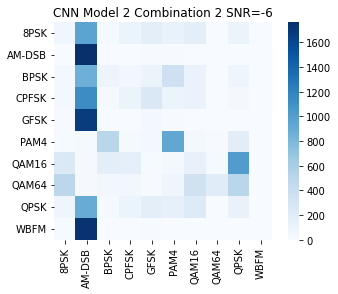

Accuracy =  0.2978770701344893


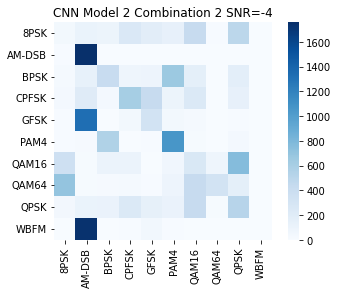

Accuracy =  0.47921420223718625


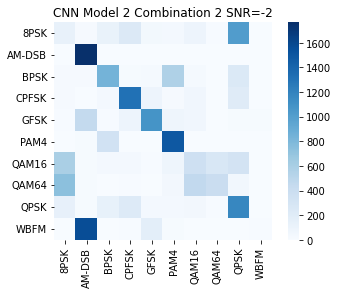

Accuracy =  0.568054554526806


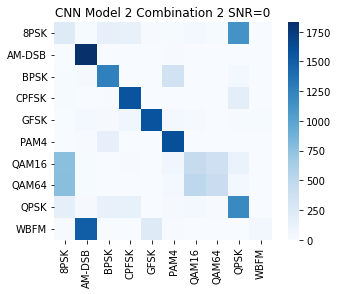

Accuracy =  0.6159533073929961


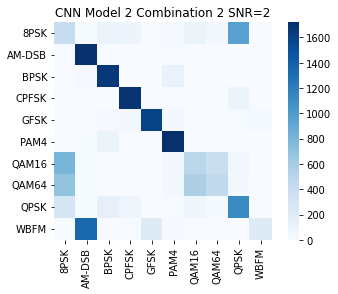

Accuracy =  0.6662382655341976


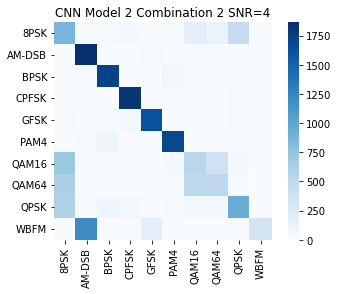

Accuracy =  0.6894736842105263


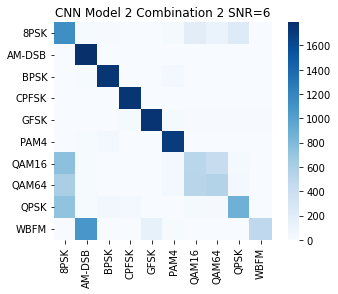

Accuracy =  0.7191910212245806


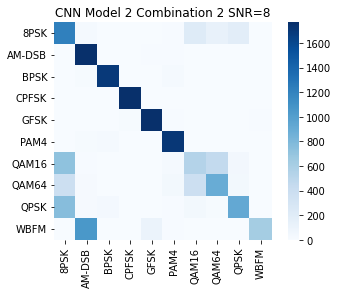

Accuracy =  0.7618143224220757


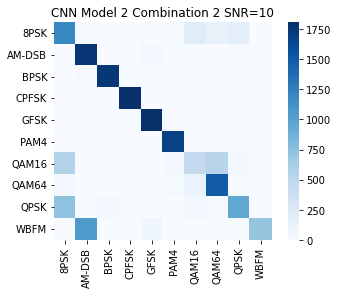

Accuracy =  0.7545988475177305


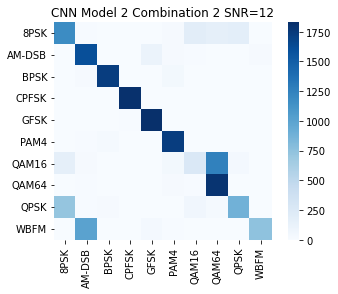

Accuracy =  0.7370735236823065


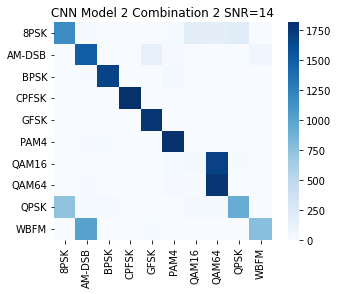

Accuracy =  0.723175487465181


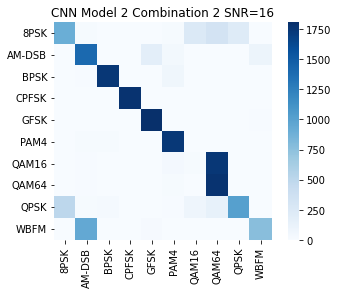

Accuracy =  0.6616433043381905


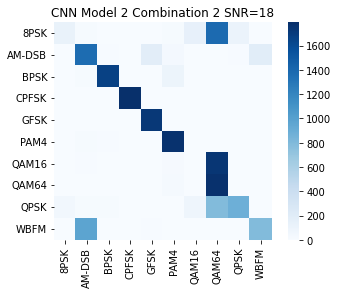

Best accuracy = 0.7618143224220757 at SNR 10


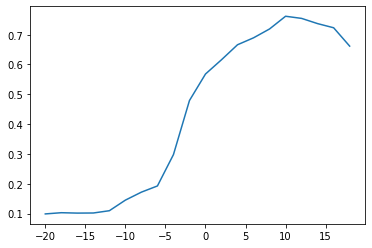

In [ ]:
plot_snrs_acc("CNN_model_22.wts.h5", "CNN Model 2 Combination 2", 2)

In [ ]:
test_model("RNN_model_2.wts.h5", 2, title="RNN Model Combination 2")

In [ ]:
plot_snrs_acc("RNN_model_2.wts.h5", "RNN Model Combination 2", 2)

In [ ]:
test_model("RNN_model_3.wts.h5", 3, title="RNN Model Combination 3")

In [ ]:
plot_snrs_acc("RNN_model_3.wts.h5", "RNN Model Combination 3", 3)

In [ ]:
test_model("RNN_model_4.wts.h5", 4, title="RNN Model Combination 4")

In [ ]:
plot_snrs_acc("RNN_model_4.wts.h5", "RNN Model Combination 4", 4)

In [ ]:
test_model("RNN_model_5.wts.h5", 5, title="RNN Model Combination 5")

In [ ]:
plot_snrs_acc("RNN_model_5.wts.h5", "RNN Model Combination 5", 5)

In [ ]:
test_model("RNN_model_6.wts.h5", 6, title="RNN Model Combination 6")

In [ ]:
plot_snrs_acc("RNN_model_6.wts.h5", "RNN Model Combination 6", 6)

In [ ]:
test_model("LSTM_model_2.wts.h5", 2, title="LSTM Model 1 Combination 2")

In [ ]:
plot_snrs_acc("LSTM_model_2.wts.h5", "LSTM Model 1 Combination 2", 2)

In [ ]:
test_model("LSTM_model_3.wts.h5", 3, title="LSTM Model 1 Combination 3")

In [ ]:
plot_snrs_acc("LSTM_model_3.wts.h5", "LSTM Model 1 Combination 3", 3)

In [ ]:
test_model("LSTM_model_4.wts.h5", 4, title="LSTM Model 1 Combination 4")

In [ ]:
plot_snrs_acc("LSTM_model_4.wts.h5", "LSTM Model 1 Combination 4", 4)

In [ ]:
test_model("LSTM_model_5.wts.h5", 5, title="LSTM Model 1 Combination 5")

In [ ]:
plot_snrs_acc("LSTM_model_5.wts.h5", "LSTM Model 1 Combination 5", 5)

In [ ]:
test_model("LSTM_model_6.wts.h5", 6, title="LSTM Model 1 Combination 6")

In [ ]:
plot_snrs_acc("LSTM_model_6.wts.h5", "LSTM Model 1 Combination 6", 6)

In [ ]:
test_model("LSTM_model_22.wts.h5", 2, title="LSTM Model 2 Combination 2")

In [ ]:
plot_snrs_acc("LSTM_model_22.wts.h5", "LSTM Model 2 Combination 2", 2)

In [ ]:
test_model("LSTM_model_32.wts.h5", 3, title="LSTM Model 2 Combination 3")

In [ ]:
plot_snrs_acc("LSTM_model_32.wts.h5", "LSTM Model 2 Combination 3", 3)

In [ ]:
test_model("LSTM_model_42.wts.h5", 4, title="LSTM Model 2 Combination 4")

In [ ]:
plot_snrs_acc("LSTM_model_42.wts.h5", "LSTM Model 2 Combination 4", 4)

In [ ]:
test_model("LSTM_model_52.wts.h5", 5, title="LSTM Model 2 Combination 5")

In [ ]:
plot_snrs_acc("LSTM_model_52.wts.h5", "LSTM Model 2 Combination 5", 5)

In [ ]:
test_model("LSTM_model_62.wts.h5", 6, title="LSTM Model 2 Combination 6")

In [ ]:
plot_snrs_acc("LSTM_model_62.wts.h5", "LSTM Model 2 Combination 6", 6)

CLDNN Model Combination 1 accuracy = 0.6073972222222223


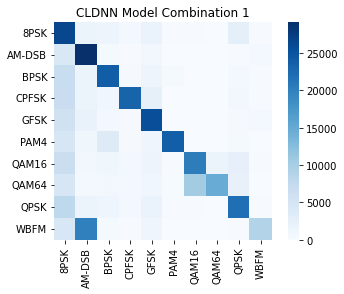

0.6073972222222223

In [ ]:
test_model("CLDNN_model_1.wts.h5", 1, title="CLDNN Model Combination 1")

CLDNN Model Combination 1 SNR=-20 accuracy = 0.10407641897145396


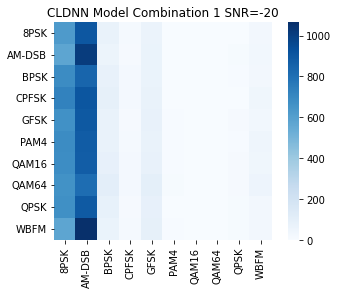

CLDNN Model Combination 1 SNR=-18 accuracy = 0.11253182774272114


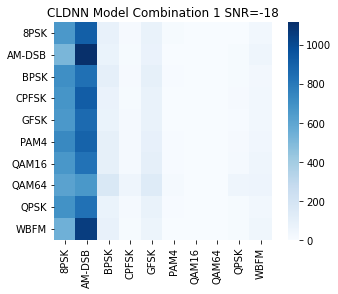

CLDNN Model Combination 1 SNR=-16 accuracy = 0.11782843299196123


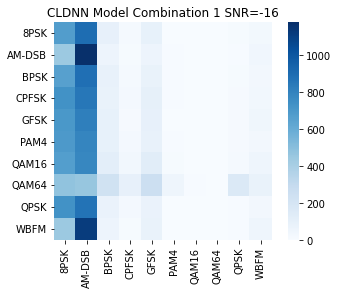

CLDNN Model Combination 1 SNR=-14 accuracy = 0.13329655172413793


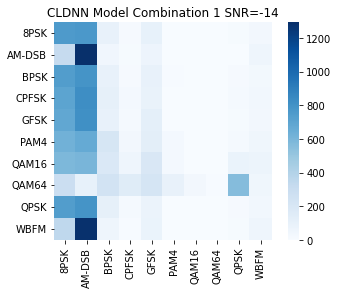

CLDNN Model Combination 1 SNR=-12 accuracy = 0.1551437132393741


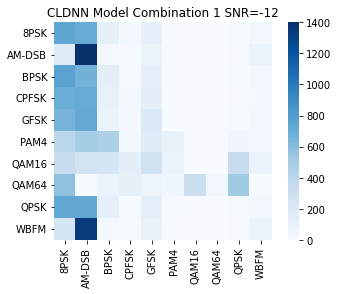

CLDNN Model Combination 1 SNR=-10 accuracy = 0.22287696882916622


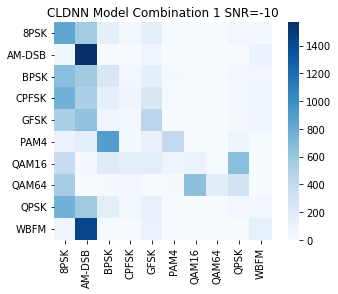

CLDNN Model Combination 1 SNR=-8 accuracy = 0.339120694483338


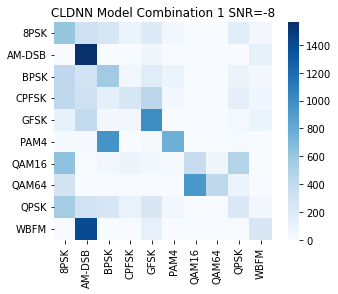

CLDNN Model Combination 1 SNR=-6 accuracy = 0.5264125710464728


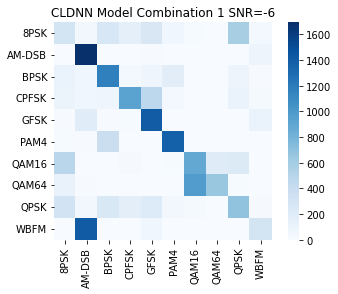

CLDNN Model Combination 1 SNR=-4 accuracy = 0.711514949427587


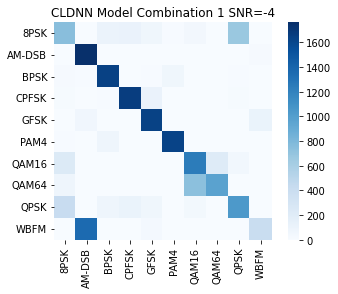

CLDNN Model Combination 1 SNR=-2 accuracy = 0.8223607323724191


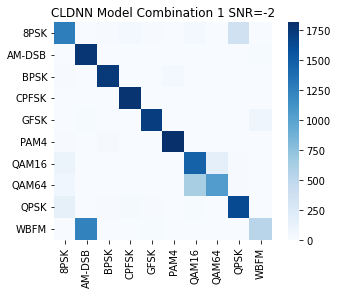

CLDNN Model Combination 1 SNR=0 accuracy = 0.8582358485335699


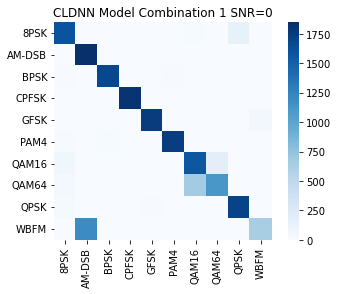

CLDNN Model Combination 1 SNR=2 accuracy = 0.8764869371873263


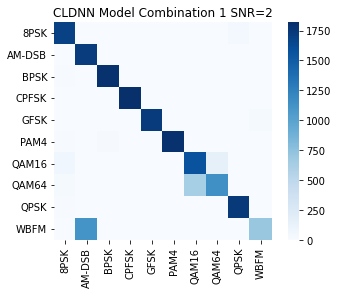

CLDNN Model Combination 1 SNR=4 accuracy = 0.8812025033527046


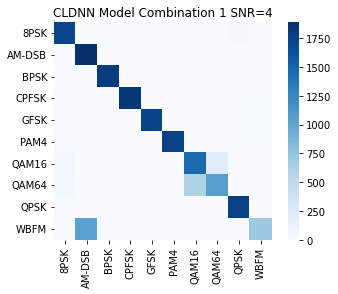

CLDNN Model Combination 1 SNR=6 accuracy = 0.8816349384098544


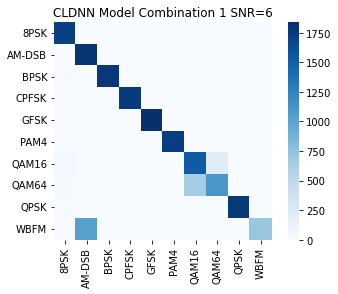

CLDNN Model Combination 1 SNR=8 accuracy = 0.8779308812090232


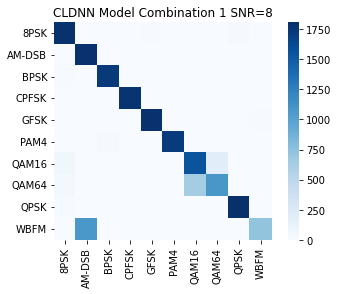

CLDNN Model Combination 1 SNR=10 accuracy = 0.876996983577254


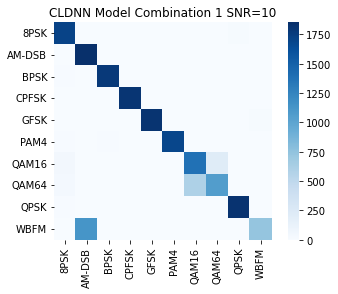

CLDNN Model Combination 1 SNR=12 accuracy = 0.8794326241134752


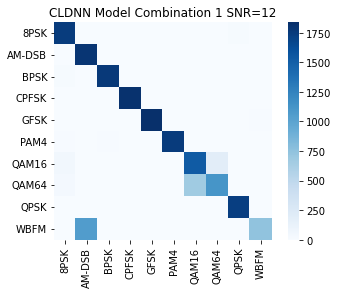

CLDNN Model Combination 1 SNR=14 accuracy = 0.8770523737964045


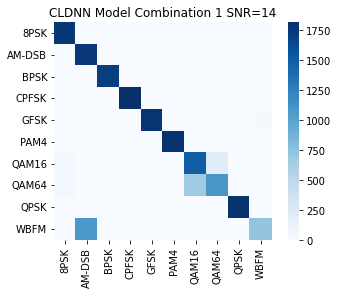

CLDNN Model Combination 1 SNR=16 accuracy = 0.8822841225626741


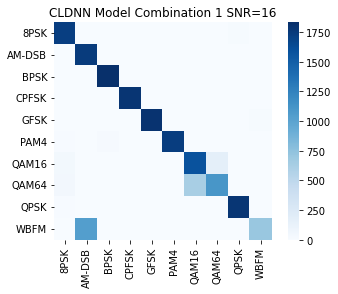

CLDNN Model Combination 1 SNR=18 accuracy = 0.882652778547288


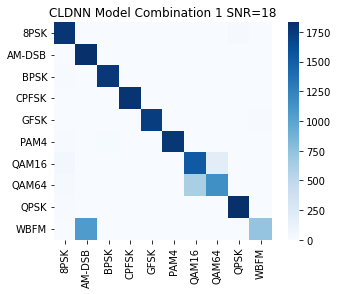

Best accuracy = 0.882652778547288 at SNR 18


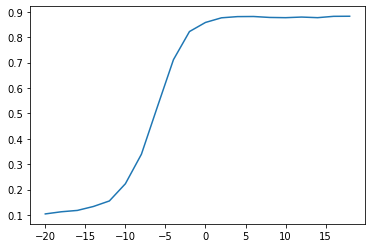

In [ ]:
plot_snrs_acc("CLDNN_model_1.wts.h5","CLDNN Model Combination 1", 1)

CLDNN Model Combination 4 accuracy = 0.6177666666666667


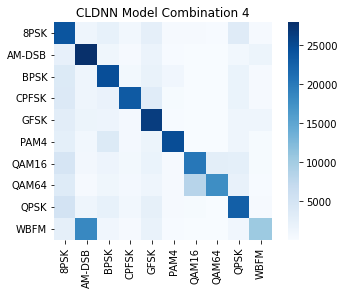

0.6177666666666667

In [ ]:
test_model("CLDNN_model_4.wts.h5", 4, title="CLDNN Model Combination 4")

CLDNN Model Combination 4 SNR=-20 accuracy = 0.10463178940353215


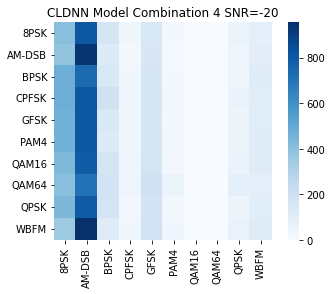

CLDNN Model Combination 4 SNR=-18 accuracy = 0.1140263478357135


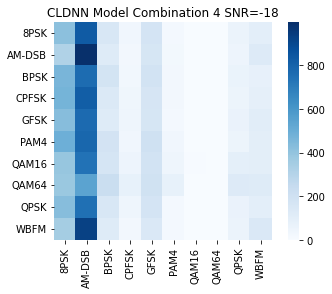

CLDNN Model Combination 4 SNR=-16 accuracy = 0.12069155379363507


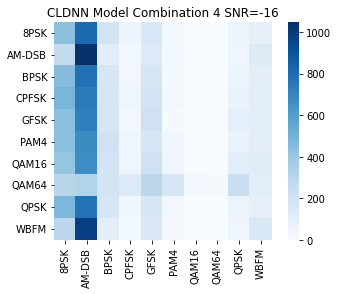

CLDNN Model Combination 4 SNR=-14 accuracy = 0.1391448275862069


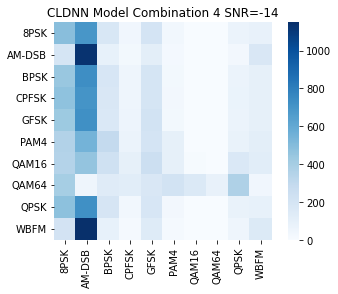

CLDNN Model Combination 4 SNR=-12 accuracy = 0.17706136943735434


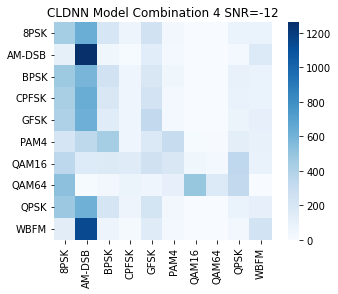

CLDNN Model Combination 4 SNR=-10 accuracy = 0.2587289349047252


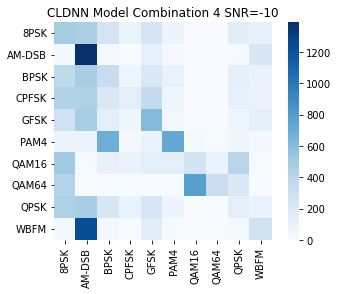

CLDNN Model Combination 4 SNR=-8 accuracy = 0.3792775133015962


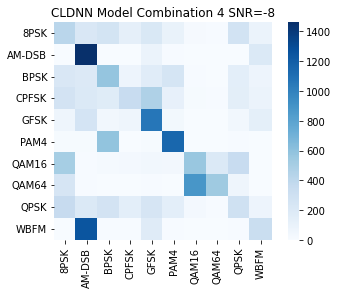

CLDNN Model Combination 4 SNR=-6 accuracy = 0.5424049927560459


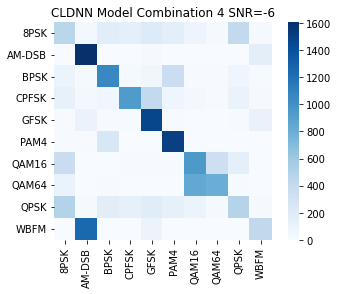

CLDNN Model Combination 4 SNR=-4 accuracy = 0.7231299321996221


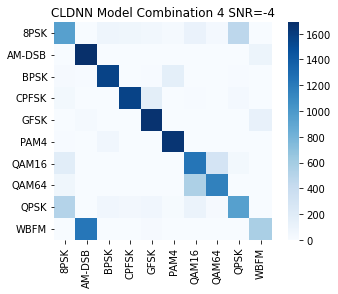

CLDNN Model Combination 4 SNR=-2 accuracy = 0.8265345873448717


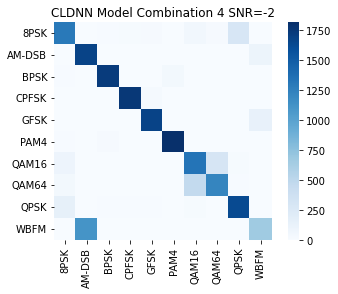

CLDNN Model Combination 4 SNR=0 accuracy = 0.864001774130953


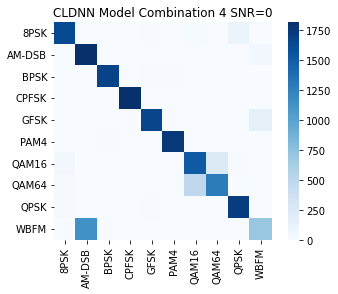

CLDNN Model Combination 4 SNR=2 accuracy = 0.8809338521400778


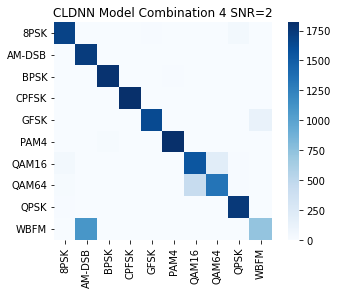

CLDNN Model Combination 4 SNR=4 accuracy = 0.8870138578453286


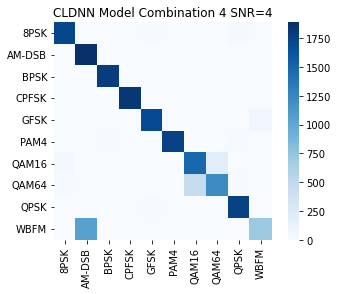

CLDNN Model Combination 4 SNR=6 accuracy = 0.8914333706606943


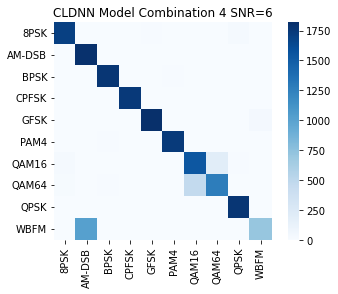

CLDNN Model Combination 4 SNR=8 accuracy = 0.8880986776308478


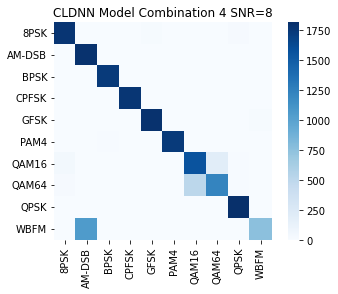

CLDNN Model Combination 4 SNR=10 accuracy = 0.8877220422299185


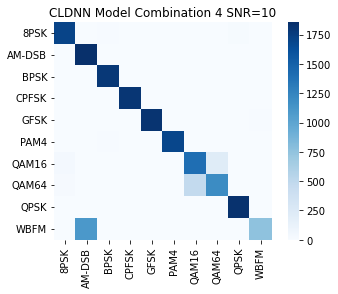

CLDNN Model Combination 4 SNR=12 accuracy = 0.8908466312056738


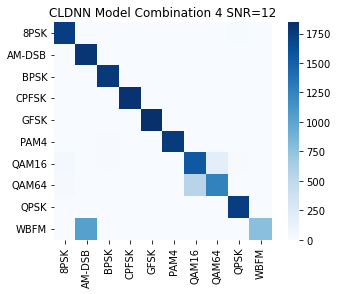

CLDNN Model Combination 4 SNR=14 accuracy = 0.8913007179829687


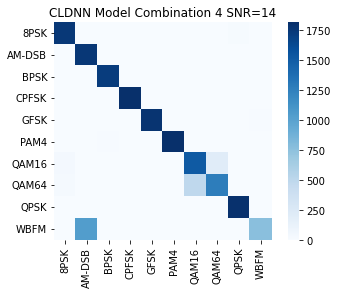

CLDNN Model Combination 4 SNR=16 accuracy = 0.8967688022284123


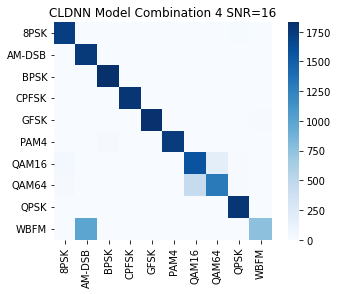

CLDNN Model Combination 4 SNR=18 accuracy = 0.8962269377804865


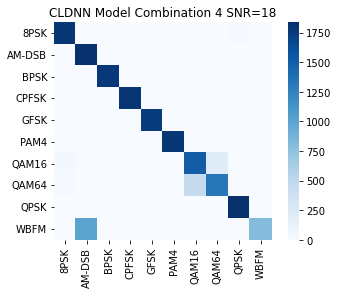

Best accuracy = 0.8967688022284123 at SNR 16


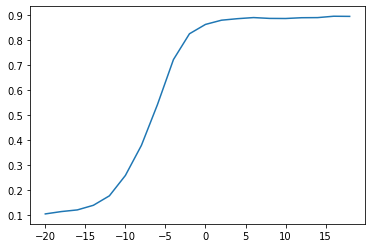

In [ ]:
plot_snrs_acc("CLDNN_model_4.wts.h5","CLDNN Model Combination 4", 4)

CLDNN Model Combination 7 accuracy = 0.6160805555555555


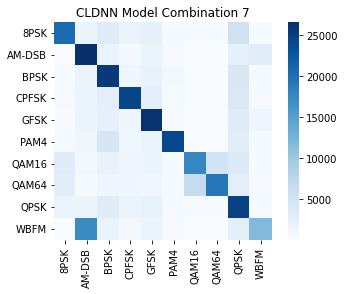

0.6160805555555555

In [ ]:
test_model("CLDNN_model_7.wts.h5", 7, title="CLDNN Model Combination 7")

CLDNN Model Combination 7 SNR=-20 accuracy = 0.10507608574919472


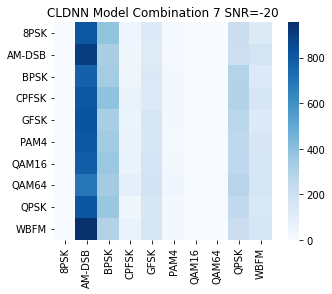

CLDNN Model Combination 7 SNR=-18 accuracy = 0.11524410494852208


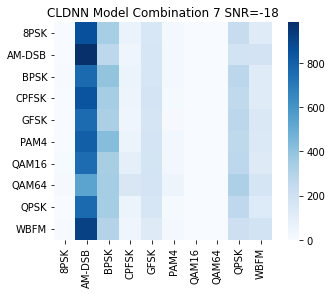

CLDNN Model Combination 7 SNR=-16 accuracy = 0.1237198546415593


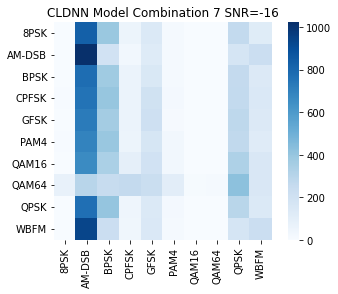

CLDNN Model Combination 7 SNR=-14 accuracy = 0.1375448275862069


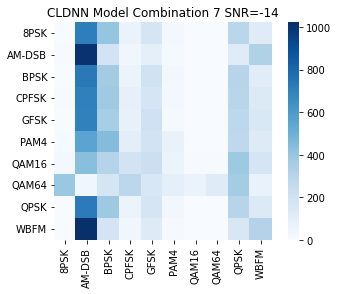

CLDNN Model Combination 7 SNR=-12 accuracy = 0.17922539118854733


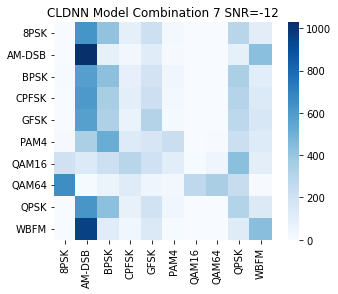

CLDNN Model Combination 7 SNR=-10 accuracy = 0.2425927965634982


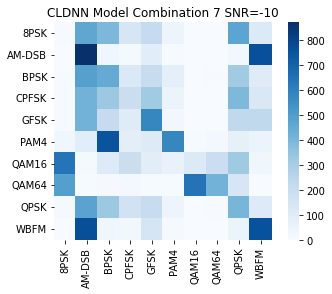

CLDNN Model Combination 7 SNR=-8 accuracy = 0.373844861383366


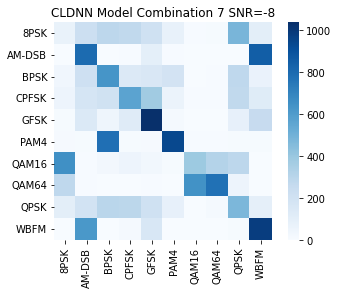

CLDNN Model Combination 7 SNR=-6 accuracy = 0.5622422824027639


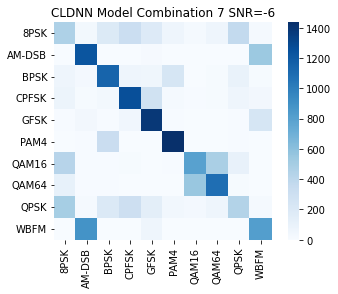

CLDNN Model Combination 7 SNR=-4 accuracy = 0.7283538957430254


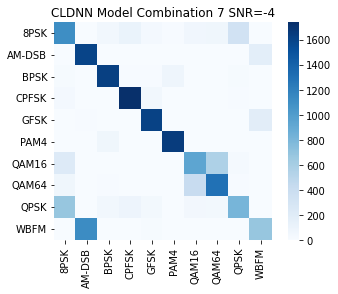

CLDNN Model Combination 7 SNR=-2 accuracy = 0.8238633201625021


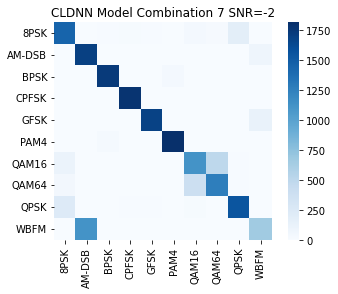

CLDNN Model Combination 7 SNR=0 accuracy = 0.8609524865554139


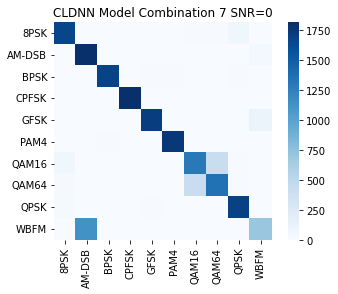

CLDNN Model Combination 7 SNR=2 accuracy = 0.8802668148971651


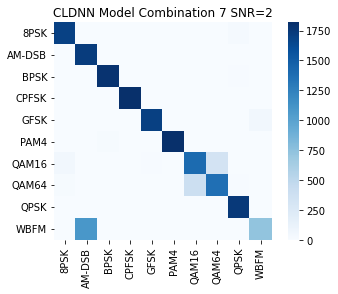

CLDNN Model Combination 7 SNR=4 accuracy = 0.8836611533303531


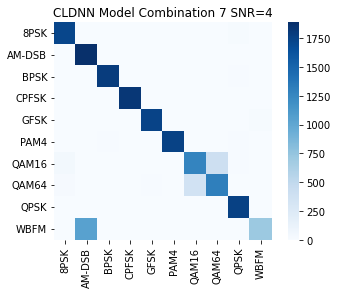

CLDNN Model Combination 7 SNR=6 accuracy = 0.8837066069428892


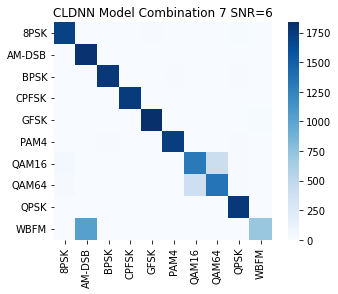

CLDNN Model Combination 7 SNR=8 accuracy = 0.8822091343482609


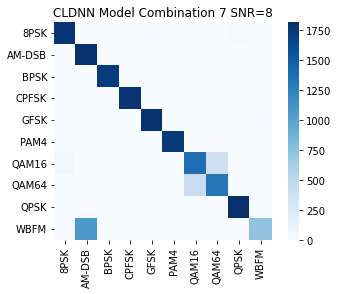

CLDNN Model Combination 7 SNR=10 accuracy = 0.8797341079209027


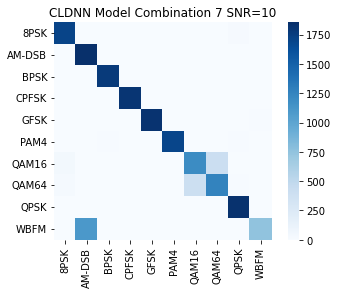

CLDNN Model Combination 7 SNR=12 accuracy = 0.8846963652482269


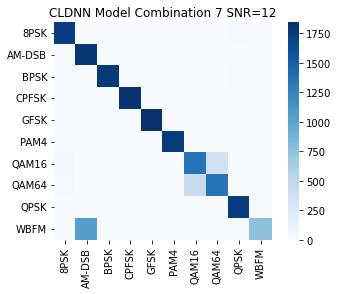

CLDNN Model Combination 7 SNR=14 accuracy = 0.8835086547559414


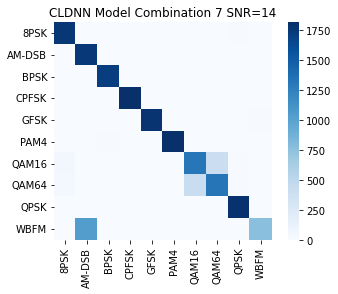

CLDNN Model Combination 7 SNR=16 accuracy = 0.889192200557103


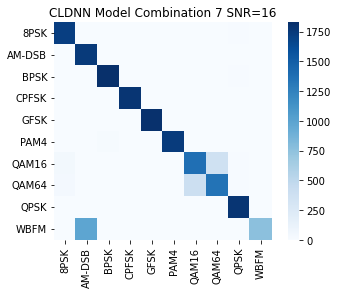

CLDNN Model Combination 7 SNR=18 accuracy = 0.8907972740872071


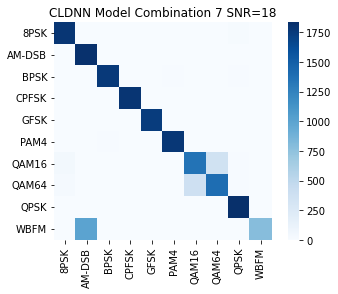

Best accuracy = 0.8907972740872071 at SNR 18


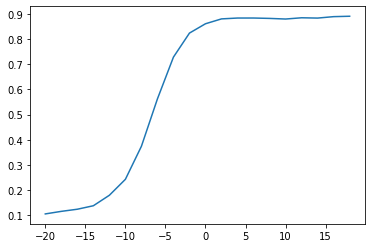

In [ ]:
plot_snrs_acc("CLDNN_model_7.wts.h5","CLDNN Model Combination 7", 7)

##Grid Search to finetune the hyperparameters and choose the best feature combination

This takes up too much RAM and eventually crashes on colab before reaching any useful conclusion

In [ ]:
from sklearn.model_selection import GridSearchCV
#TODO: finish this
def do_grid_search(model, feat_pipeline):
  model_pipeline = Pipeline([
                             ("feat_pipeline", feat_pipeline),
                              ("model", model)
  ])
  param_grid = [{
                "model__dr":[ 0.0, 0.5, 0.9],
                "model__learning_rate": [0.001, 0.01, 0.1]}
                ]
  grid_search = GridSearchCV(model_pipeline, param_grid, cv=3, 
                            scoring="neg_mean_squared_error", 
                            return_train_score=True,
                             verbose=2,
                             n_jobs=None,
                             error_score='raise')
  grid_search.fit(X_train, y_train)
  return grid_search

In [ ]:
#grid_search = do_grid_search(CNNmodel, feat_pipeline)